## Daily Sun Spot Data (1818 to 2019)
### Can you forecast sun spots? One of the greatest mysteries in Solar Physics

Il numero totale di macchie solari deriva da: \
$R = Ns + 10*Ng $ \
(numero di Wolf)\
dove: 
- Ns è il numero di macchie
- Ng il numero di gruppi contati sull'intero disco solare

Non vengono forniti dati giornalieri prima del 1818 perché le osservazioni giornaliere sono diventate troppo poche negli anni precedenti. Pertanto, R. Wolf ha compilato solo le medie mensili e le medie annuali per tutti gli anni prima del 1818.\
\
I valori mancanti sono contrassegnati da -1 (il numero di macchie solari valido è sempre positivo).\
\
Gli errori corrispondono alla deviazione standard. Prima del 1981, gli errori sono stimati con l'aiuto di un modello auto-regressivo basato sulla distribuzione poissoniana dei numeri effettivi di macchie solari. Dal 1981 in poi, il valore di errore è la deviazione standard effettiva del campione di osservazioni grezze utilizzato per calcolare il valore giornaliero.\
L'errore standard del numero giornaliero di macchie solari può essere calcolato da: \
$\sigma / sqrt(N)$ \
dove: 
- $\sigma$ è la deviazione standard elencata
- N il numero di osservazioni per giorno 

Prima del 1981, il numero di osservazioni era impostato su 1, poiché il numero di macchie solari era essenzialmente il numero grezzo di Wolf dell'Osservatorio di Zurigo.

### Studio e pulizia del dataset

Descrizione delle colonne: 
- Unnamed: ID 
- Year, month, day: anno, mese, giorno
- Date In Fraction Of Year: data in frazioni di anni
- Number of Sunspots: numero totale giornaliero di macchie solari
- Standard Deviation: deviazione standard giornaliera del numero di macchie solari in input da una stazione individuale
- Observations: numero di osservazioni usate per calcolare il valore giornaliero
- Indicator: indicatore definitivo/provvisorio. Uno spazio vuoto indica che il valore è definitivo. Un simbolo '*' indica che il valore è ancora provvisorio ed è soggetto a una possibile revisione (di solito negli ultimi 3-6 mesi)

In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import scipy.stats.distributions as dist
import seaborn as sns
from datetime import datetime 

In [2]:
#leggo il dataset
sun = pd.read_table("sunspot_data.csv", sep = ",")

In [3]:
sun.head()

Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
0           0  1818      1    1                  1818.001                  -1   
1           1  1818      1    2                  1818.004                  -1   
2           2  1818      1    3                  1818.007                  -1   
3           3  1818      1    4                  1818.010                  -1   
4           4  1818      1    5                  1818.012                  -1   

   Standard Deviation  Observations  Indicator  
0                -1.0             0          1  
1                -1.0             0          1  
2                -1.0             0          1  
3                -1.0             0          1  
4                -1.0             0          1

In [4]:
sun.tail()

Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  \
73713       73713  2019     10   27                  2019.821   
73714       73714  2019     10   28                  2019.823   
73715       73715  2019     10   29                  2019.826   
73716       73716  2019     10   30                  2019.829   
73717       73717  2019     10   31                  2019.832   

       Number of Sunspots  Standard Deviation  Observations  Indicator  
73713                   0                 0.0            34          0  
73714                   0                 0.0            34          0  
73715                   0                 0.0            30          0  
73716                   0                 0.0            24          0  
73717                   0                 0.0            28          0

In [5]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73718 entries, 0 to 73717
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                73718 non-null  int64  
 1   Year                      73718 non-null  int64  
 2   Month                     73718 non-null  int64  
 3   Day                       73718 non-null  int64  
 4   Date In Fraction Of Year  73718 non-null  float64
 5   Number of Sunspots        73718 non-null  int64  
 6   Standard Deviation        73718 non-null  float64
 7   Observations              73718 non-null  int64  
 8   Indicator                 73718 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.1 MB


In [6]:
sun.shape

(73718, 9)

In [7]:
sun.describe()

Unnamed: 0          Year         Month           Day  \
count  73718.000000  73718.000000  73718.000000  73718.000000   
mean   36858.500000   1918.416750      6.518896     15.729347   
std    21280.697909     58.264401      3.447114      8.800032   
min        0.000000   1818.000000      1.000000      1.000000   
25%    18429.250000   1868.000000      4.000000      8.000000   
50%    36858.500000   1918.000000      7.000000     16.000000   
75%    55287.750000   1969.000000     10.000000     23.000000   
max    73717.000000   2019.000000     12.000000     31.000000   

       Date In Fraction Of Year  Number of Sunspots  Standard Deviation  \
count              73718.000000        73718.000000        73718.000000   
mean                1918.916406           79.248732            6.924587   
std                   58.264520           77.470942            4.778793   
min                 1818.001000           -1.000000           -1.000000   
25%                 1868.458500           15.000000            3.000000   
50%                 1918.917500           58.000000            6.600000   
75%                 1969.373250          125.000000           10.000000   
max                 2019.832000          528.000000           77.700000   

       Observations     Indicator  
count  73718.000000  73718.000000  
mean       4.429678      0.998331  
std        7.884112      0.040814  
min        0.000000      0.000000  
25%        1.000000      1.000000  
50%        1.000000      1.000000  
75%        1.000000      1.000000  
max       60.000000      1.000000

In [8]:
#creo una copia su cui lavorare
sun_copy = sun.copy()

In [9]:
sun_copy.duplicated().sum() #non ci sono duplicati

0

In [10]:
#Il valore -1 indica in questo dataset i valori mancanti: quanti sono?  
sun_copy[sun_copy['Number of Sunspots']==-1].count() 

Unnamed: 0                  3247
Year                        3247
Month                       3247
Day                         3247
Date In Fraction Of Year    3247
Number of Sunspots          3247
Standard Deviation          3247
Observations                3247
Indicator                   3247
dtype: int64

In [11]:
#dove sono?
sun_copy[sun_copy['Number of Sunspots']==-1].groupby('Year').count()
#i valori sono solo nel periodo iniziale (primi 48 anni) quindi posso eliminarli senza conseguenze sull'intero set di dati
#dato che l'intero set ricopre un periodo di 200 anni 

Unnamed: 0  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
Year                                                                         
1818         152    152  152                       152                 152   
1819         116    116  116                       116                 116   
1820         142    142  142                       142                 142   
1821          61     61   61                        61                  61   
1822          12     12   12                        12                  12   
1823          63     63   63                        63                  63   
1824         172    172  172                       172                 172   
1825          55     55   55                        55                  55   
1826          45     45   45                        45                  45   
1827          44     44   44                        44                  44   
1828          65     65   65                        65                  65   
1829          74     74   74                        74                  74   
1830          97     97   97                        97                  97   
1831          80     80   80                        80                  80   
1832          89     89   89                        89                  89   
1833          73     73   73                        73                  73   
1834         105    105  105                       105                 105   
1835         192    192  192                       192                 192   
1836         200    200  200                       200                 200   
1837         215    215  215                       215                 215   
1838         164    164  164                       164                 164   
1839         171    171  171                       171                 171   
1840         118    118  118                       118                 118   
1841          88     88   88                        88                  88   
1842          54     54   54                        54                  54   
1843          45     45   45                        45                  45   
1844          72     72   72                        72                  72   
1845         100    100  100                       100                 100   
1846         118    118  118                       118                 118   
1847         133    133  133                       133                 133   
1848         132    132  132                       132                 132   

      Standard Deviation  Observations  Indicator  
Year                                               
1818                 152           152        152  
1819                 116           116        116  
1820                 142           142        142  
1821                  61            61         61  
1822                  12            12         12  
1823                  63            63         63  
1824                 172           172        172  
1825                  55            55         55  
1826                  45            45         45  
1827                  44            44         44  
1828                  65            65         65  
1829                  74            74         74  
1830                  97            97         97  
1831                  80            80         80  
1832                  89            89         89  
1833                  73            73         73  
1834                 105           105        105  
1835                 192           192        192  
1836                 200           200        200  
1837                 215           215        215  
1838                 164           164        164  
1839                 171           171        171  
1840                 118           118        118  
1841                  88            88         88  
1842                  54            54         54  
1843                  45   

In [12]:
#in totale ci sono 3247 valori mancanti. Li elimino 
sun_copy=sun_copy.drop(sun_copy[sun_copy['Number of Sunspots']==-1].index, axis=0)
sun_copy.head()

Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  \
7            7  1818      1    8                  1818.021   
12          12  1818      1   13                  1818.034   
16          16  1818      1   17                  1818.045   
17          17  1818      1   18                  1818.048   
18          18  1818      1   19                  1818.051   

    Number of Sunspots  Standard Deviation  Observations  Indicator  
7                   65                10.2             1          1  
12                  37                 7.7             1          1  
16                  77                11.1             1          1  
17                  98                12.6             1          1  
18                 105                13.0             1          1

In [13]:
#verifico che siano stati eliminati correttamente
sun_copy[sun_copy['Number of Sunspots']==-1].count() 

Unnamed: 0                  0
Year                        0
Month                       0
Day                         0
Date In Fraction Of Year    0
Number of Sunspots          0
Standard Deviation          0
Observations                0
Indicator                   0
dtype: int64

In [14]:
sun_copy.shape

(70471, 9)

In [15]:
#Unnamed è l'ID del dataset ma c'è quello impostato automaticamente, quindi elimino la colonna
sun_copy = sun_copy.drop('Unnamed: 0', 1)

In [16]:
sun_copy.head()

Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
7   1818      1    8                  1818.021                  65   
12  1818      1   13                  1818.034                  37   
16  1818      1   17                  1818.045                  77   
17  1818      1   18                  1818.048                  98   
18  1818      1   19                  1818.051                 105   

    Standard Deviation  Observations  Indicator  
7                 10.2             1          1  
12                 7.7             1          1  
16                11.1             1          1  
17                12.6             1          1  
18                13.0             1          1

In [17]:
#Indicator: non sono indicati con ' ' p '*'. Con cosa sono indicati? 
sun_copy['Indicator'].unique()

array([1, 0], dtype=int64)

In [18]:
sun_copy[sun_copy['Indicator']==0]

Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
73595  2019      7    1                  2019.497                   5   
73596  2019      7    2                  2019.500                   0   
73597  2019      7    3                  2019.503                   0   
73598  2019      7    4                  2019.505                   0   
73599  2019      7    5                  2019.508                   0   
...     ...    ...  ...                       ...                 ...   
73713  2019     10   27                  2019.821                   0   
73714  2019     10   28                  2019.823                   0   
73715  2019     10   29                  2019.826                   0   
73716  2019     10   30                  2019.829                   0   
73717  2019     10   31                  2019.832                   0   

       Standard Deviation  Observations  Indicator  
73595                 0.5            14          0  
73596                 0.0            39          0  
73597                 0.0            39          0  
73598                 0.0            39          0  
73599                 0.0            39          0  
...                   ...           ...        ...  
73713                 0.0            34          0  
73714                 0.0            34          0  
73715                 0.0            30          0  
73716                 0.0            24          0  
73717                 0.0            28          0  

[123 rows x 8 columns]

Quindi l'indicatore può valere o 1 se definito o 0 se non definito. Infatti 0 si trova solo nelle ultime righe. 

In [19]:
#numero di volte in cui non si sono osservate macchie solari
sun_copy[sun_copy['Number of Sunspots']==0].count()

Year                        11101
Month                       11101
Day                         11101
Date In Fraction Of Year    11101
Number of Sunspots          11101
Standard Deviation          11101
Observations                11101
Indicator                   11101
dtype: int64

In [20]:
#rinomino le colonne
sun_copy = sun_copy.rename(columns={'Year':'year','Month':'month', 'Day':'day','Date In Fraction Of Year':'date_frac',
                                   'Number of Sunspots':'sunspots','Standard Deviation':'devsta', 'Observations':'observations',
                                   'Indicator':'indicator'})
sun_copy.columns

Index(['year', 'month', 'day', 'date_frac', 'sunspots', 'devsta',
       'observations', 'indicator'],
      dtype='object')

In [21]:
#creo una colonna data che mi faccia da indice 
sun_copy['data']=sun_copy[['year', 'month', 'day']].apply(lambda x: datetime(*x),axis = 1)
sun_copy.index = sun_copy['data']
sun_copy = sun_copy.drop('data', 1)
sun_copy.head()

year  month  day  date_frac  sunspots  devsta  observations  \
data                                                                      
1818-01-08  1818      1    8   1818.021        65    10.2             1   
1818-01-13  1818      1   13   1818.034        37     7.7             1   
1818-01-17  1818      1   17   1818.045        77    11.1             1   
1818-01-18  1818      1   18   1818.048        98    12.6             1   
1818-01-19  1818      1   19   1818.051       105    13.0             1   

            indicator  
data                   
1818-01-08          1  
1818-01-13          1  
1818-01-17          1  
1818-01-18          1  
1818-01-19          1

Ha senso studiare la variazione del numero totale giornaliero di macchie solari, il numero di osservazioni e la distribuzione della deviazione standard.

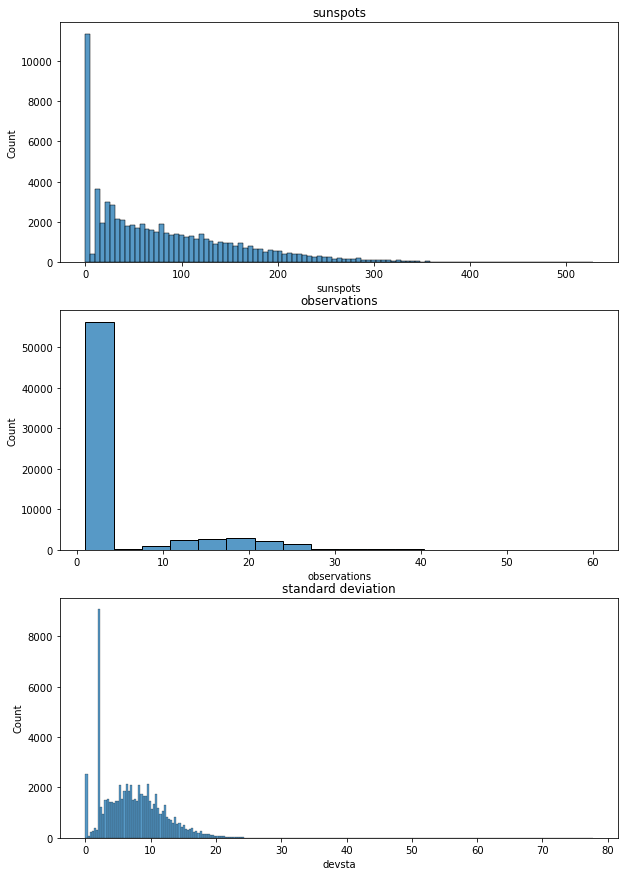

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(3,1, figsize=(10,15))
axes[0].set_title('sunspots')
sns.histplot(x=sun_copy.sunspots, ax=axes[0])
axes[1].set_title('observations')
sns.histplot(x=sun_copy.observations, ax=axes[1])
axes[2].set_title('standard deviation')
sns.histplot(x=sun_copy.devsta, ax=axes[2])
plt.show()

I grafici sono spostati verso sinistra perchè ci sono dei casi isolati con valori alti fuori dalle distribuzioni

In [23]:
sun_copy[sun_copy.devsta >30]

year  month  day  date_frac  sunspots  devsta  observations  \
data                                                                      
1981-09-29  1981      9   29   1981.744       280    77.7             7   
1981-11-02  1981     11    2   1981.837       301    40.5             3   
1981-11-03  1981     11    3   1981.840       295    33.1             6   
1982-02-01  1982      2    1   1982.086       364    32.3            10   
1982-07-14  1982      7   14   1982.533       292    33.0             8   
1982-11-12  1982     11   12   1982.864       108    33.8            11   
1982-11-20  1982     11   20   1982.886       153    60.1            12   
1991-08-22  1991      8   22   1991.640       401    37.7            24   
1991-10-29  1991     10   29   1991.826       339    30.4            17   

            indicator  
data                   
1981-09-29          1  
1981-11-02          1  
1981-11-03          1  
1982-02-01          1  
1982-07-14          1  
1982-11-12          1  
1982-11-20          1  
1991-08-22          1  
1991-10-29          1

In [24]:
sun_copy[sun_copy.sunspots > 400]

year  month  day  date_frac  sunspots  devsta  observations  \
data                                                                      
1837-02-21  1837      2   21   1837.141       435    26.4             1   
1838-03-01  1838      3    1   1838.163       407    25.5             1   
1847-08-16  1847      8   16   1847.623       423    26.1             1   
1847-08-17  1847      8   17   1847.626       410    25.7             1   
1847-10-12  1847     10   12   1847.779       408    25.6             1   
...          ...    ...  ...        ...       ...     ...           ...   
1959-09-01  1959      9    1   1959.667       411    13.6             1   
1979-11-10  1979     11   10   1979.859       428    13.9             1   
1979-11-11  1979     11   11   1979.862       418    13.7             1   
1991-08-21  1991      8   21   1991.637       410    22.0            25   
1991-08-22  1991      8   22   1991.640       401    37.7            24   

            indicator  
data                   
1837-02-21          1  
1838-03-01          1  
1847-08-16          1  
1847-08-17          1  
1847-10-12          1  
...               ...  
1959-09-01          1  
1979-11-10          1  
1979-11-11          1  
1991-08-21          1  
1991-08-22          1  

[74 rows x 8 columns]

In [25]:
sun_copy[sun_copy.observations > 50]

year  month  day  date_frac  sunspots  devsta  observations  \
data                                                                      
2016-03-17  2016      3   17   2016.209        72     6.3            57   
2016-04-12  2016      4   12   2016.280        37     3.2            52   
2016-04-20  2016      4   20   2016.302        25     2.5            52   
2016-04-21  2016      4   21   2016.305        26     2.5            54   
2016-05-04  2016      5    4   2016.340        71     5.5            54   
...          ...    ...  ...        ...       ...     ...           ...   
2018-10-22  2018     10   22   2018.807         0     0.0            54   
2019-03-29  2019      3   29   2019.240         0     0.0            52   
2019-04-11  2019      4   11   2019.275        12     0.8            51   
2019-04-22  2019      4   22   2019.305         0     0.0            54   
2019-06-27  2019      6   27   2019.486         0     0.0            51   

            indicator  
data                   
2016-03-17          1  
2016-04-12          1  
2016-04-20          1  
2016-04-21          1  
2016-05-04          1  
...               ...  
2018-10-22          1  
2019-03-29          1  
2019-04-11          1  
2019-04-22          1  
2019-06-27          1  

[74 rows x 8 columns]

Osservazioni: 
- Il numero di macchie solari ha un andamento assimilabile a un esponenziale. 
- Le osservazioni hanno un andamento gaussiano se si esclude il valre 1. Infatti prima del 1981 il numero di osservazioni era impostato su 1 e questo spiega la preponderanza di questo valore. 
- la deviazione standard ha un andamento gaussiano. Bisogna comunque tener conto che la deviazione standard è calcolata in modo diverso prima e doppo il 1981. I due picchi corrispondono ai valori 0 e 2 (come mostrato in seguito). Probabilmente si trovano in corrispondenza di un numero di macchie solari uguale a zero perchè questo valore si ripete maggiormente. 

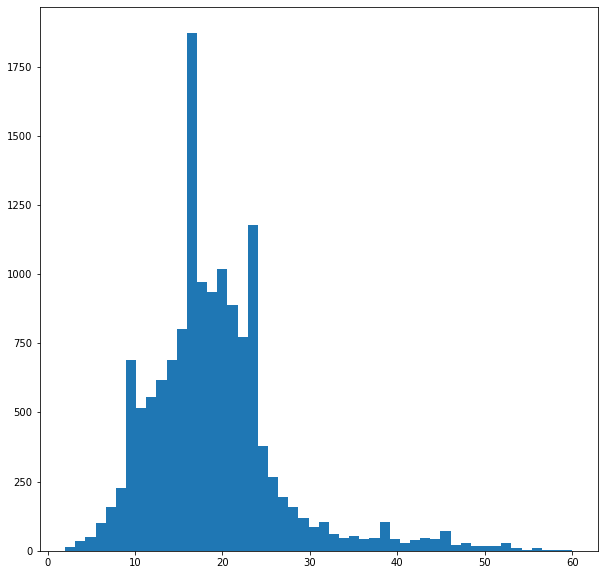

In [26]:
#verifico andamento gaussiano delle osservazioni senza 1
fig=plt.figure(figsize=(10,10))
_ = plt.hist(sun_copy.observations[sun_copy.observations != 1], bins = 50)

In [27]:
#valori dei picchi nella deviazione standard 
sun_copy.devsta.value_counts()

2.0     8753
0.0     2522
3.0      945
6.3      804
3.3      798
        ... 
33.0       1
24.1       1
32.3       1
26.0       1
26.2       1
Name: devsta, Length: 277, dtype: int64

### Correlazioni tra variabili 

Dalle distribuzioni appena studite, la deviazione standard sembra essere collegata al numero di macchie solari. \
Attraverso la heatmap verifichiamo le correlazioni.

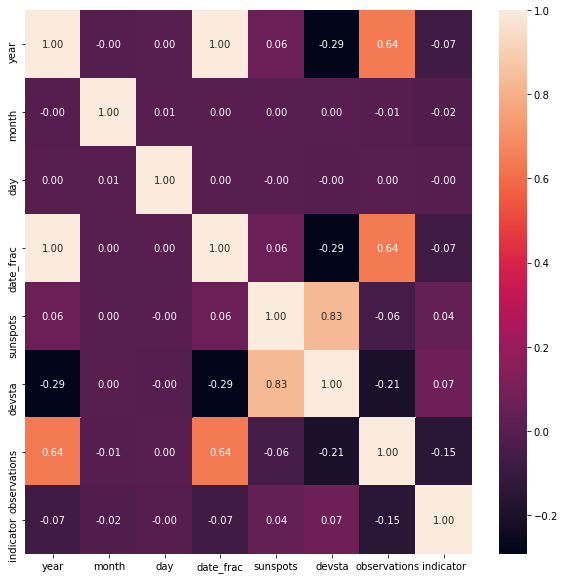

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sun_copy.corr(), annot=True, fmt='.2f')
plt.show() 

Correlazioni rilevanti tra: 
- numero di macchie solari e deviazione standard
- osservazioni e data di osservazione 

Non si osserva correlazione tra il numero di macchie e le osservazioni, proviamo quindi a vedere l'heatmap considerando solo il periodo successivo al 1981. Infatti prima di tale data le osservazioni erano poste uguali a 1 e ciò potrebbe alterare il risultato. 

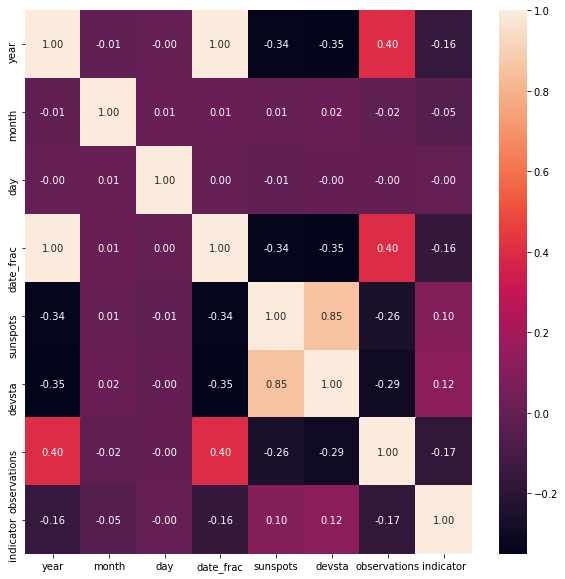

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sun_copy[sun_copy['date_frac']>1981].corr(), annot=True, fmt='.2f')
plt.show()

Considerando solo il periodo successivo al 1981 la correlazione passa da -0.06 a -0.26. Quindi non c'è comunque correlazione significativa tra il numero di macchie solari e le osservazioni. Le osservazioni sono però correlate con l'anno.

Un test di ipotesi interessante che si può fare sulla base delle considerazioni tratte fino ad ora è: 
- Deviazione stadard: i picchi in 0 e in 2 corrispondono ai casi in cui non si osservano macchie solari? 



#### Deviazione standard - i picchi in 0 e in 2 corrispondono ai casi in cui non si osservano macchie solari? 

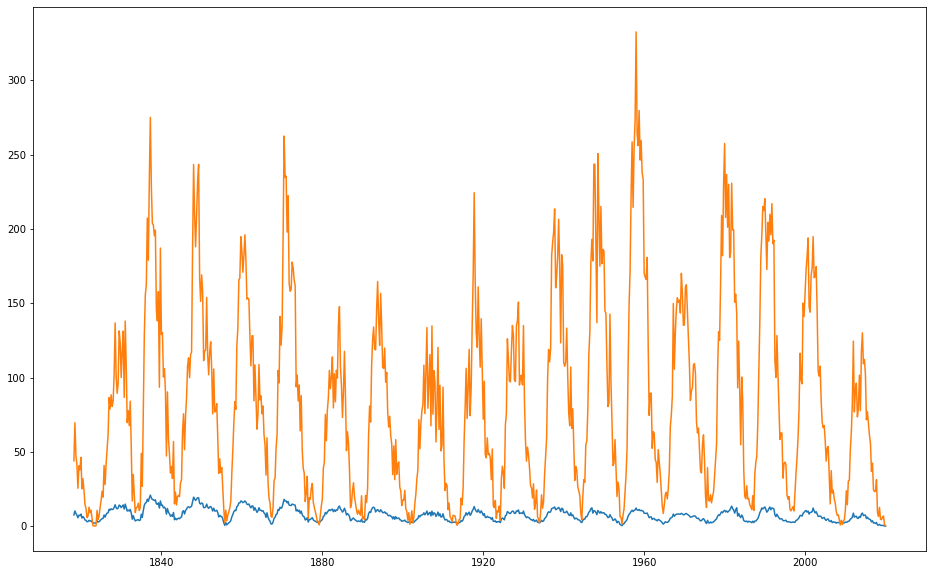

In [30]:
#ricampiono i dati per chiarezza di visualizzazione nel grafico
resample_devsta = sun_copy.devsta.resample('Q').mean()
resample_sunspot = sun_copy.sunspots.resample('Q').mean()
fig=plt.figure(figsize=(16,10))
plt.plot(resample_devsta)
plt.plot(resample_sunspot)

In [31]:
#funzione per stampare due dataframe affiancati
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [32]:
#creazione elementi dataframe
devsta_0=sun_copy[(sun_copy.devsta==0)]
devsta_0_grouped_s=devsta_0.groupby(['sunspots',np.where((devsta_0.year<1981), '<1981', '>1981')]).agg({'devsta': ['count']})
devsta_0_grouped_s.columns = ['Devsta 0 Count']
devsta_2=sun_copy[(sun_copy.devsta==2)]
devsta_2_grouped_s=devsta_2.groupby(['sunspots',np.where((devsta_2.year<1981), '<1981', '>1981')]).agg({'devsta': ['count']})
devsta_2_grouped_s.columns = ['Devsta 2 Count']

In [33]:
display_side_by_side(devsta_0_grouped_s, devsta_2_grouped_s.head(5))
a=devsta_0_grouped_s[np.in1d(devsta_0_grouped_s.index.get_level_values(0), [0])].sum()
b=devsta_2_grouped_s[np.in1d(devsta_2_grouped_s.index.get_level_values(0), [0])].sum()
print("Sunspots 0: \n    devsta 0 sum -> ", a[0])
print("    devsta 2 sum -> ", b[0])

Devsta 0 Count 
 
 
 sunspots 
 
 
 
 
 
 
 0 
 <1981 
 1967 
 
 
 >1981 
 550 
 
 
 11 
 >1981 
 1 
 
 
 12 
 >1981 
 2 
 
 
 14 
 >1981 
 2 
 
 
 
 
 
 
 
 Devsta 2 Count 
 
 
 sunspots 
 
 
 
 
 
 
 0 
 <1981 
 7184 
 
 
 >1981 
 1400 
 
 
 2 
 <1981 
 24 
 
 
 3 
 <1981 
 12 
 
 
 4 
 >1981 
 1

Sunspots 0: 
    devsta 0 sum ->  2517
    devsta 2 sum ->  8584


La deviazione standard assume questi due valori (0 e 2) soprattutto quando nsunspots è uguale a zero. Il calcolo della deviazione standard cambia prima e dopo il 1981, valuto se tali valori dipendono dal periodo in cui sono stati calcolati. 

In [34]:
devsta_0=sun_copy[(sun_copy.devsta==0)]
devsta_0_grouped_o=devsta_0.groupby(['observations',np.where((devsta_0.year<1981), '<1981', '>1981')]).agg({'devsta': ['count']})
devsta_0_grouped_o.columns = ['Devsta 0 Count']
devsta_2=sun_copy[(sun_copy.devsta==2)]
devsta_2_grouped_o=devsta_2.groupby(['observations',np.where((devsta_2.year<1981), '<1981', '>1981')]).agg({'devsta': ['count']})
devsta_2_grouped_o.columns = ['Devsta 2 Count']

display_side_by_side(devsta_0_grouped_o.head(), devsta_2_grouped_o.head())

Devsta 0 Count 
 
 
 observations 
 
 
 
 
 
 
 1 
 <1981 
 1967 
 
 
 7 
 >1981 
 2 
 
 
 8 
 >1981 
 2 
 
 
 10 
 >1981 
 1 
 
 
 11 
 >1981 
 1 
 
 
 
 
 
 
 
 Devsta 2 Count 
 
 
 observations 
 
 
 
 
 
 
 1 
 <1981 
 7226 
 
 
 4 
 >1981 
 1 
 
 
 5 
 >1981 
 1 
 
 
 6 
 >1981 
 2 
 
 
 7 
 >1981 
 3

Tutte le osservazioni prima del 1981 con deviazione standard uguale a 0 hanno un numero di macchie solari pari a zero. 

I valori sono più frequenti prima del 1981 ma si presentano comunque in grande quantità anche nel periodo successivo. Quindi 0 e 2 non dipendono dal metodo di calcolo della deviazione standard. Piuttosto potrebbero dipendere dal fatto che il numero di volte in cui il numero di macchie è zero è nettamente maggiore rispetto agli altri valori assunti, come si vede dall'istogramma precedente. Di conseguenza è chiaro che dipende dal numero di macchie e non dal periodo storico come già risultava nella heatmap.  

##### test ipotesi 
Se devsta = 0 o devsta = 2: 
- HP0: sunspot = 0
- HP1: sunspot != 0

Non posso farlo perchè sunspots ha un andamento esponenziale e non gaussiano! Devo trasformarlo con i logaritmi ma logaritmo di 0 è infinito. Non riesco a trasformare la distribuione in una gaussiana. Da approfondire. \
https://www.researchgate.net/post/Log_transformation_of_values_that_include_0_zero_for_statistical_analyses2

#### Osservazioni 

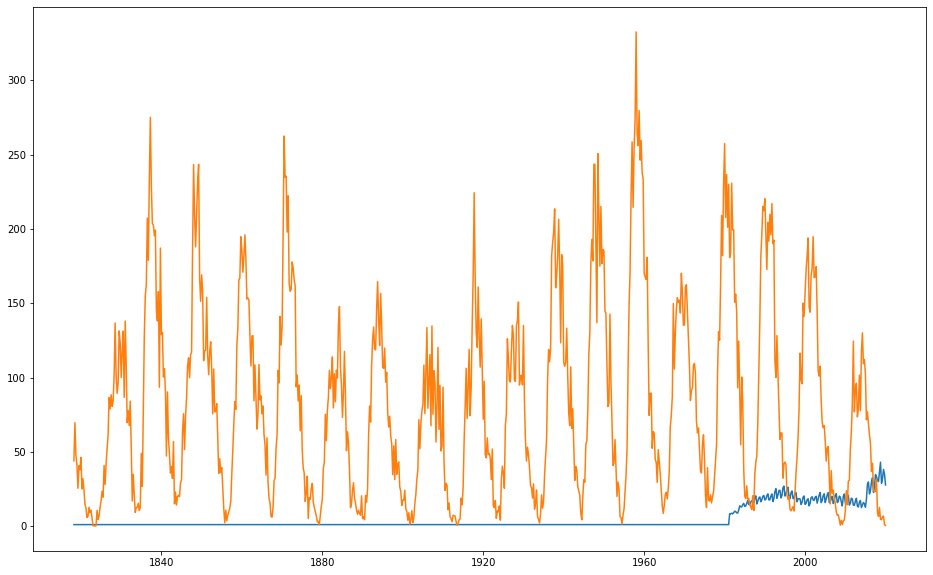

In [35]:
#ricampiono i dati per chiarezza di visualizzazione nel grafico
resample_obs = sun_copy.observations.resample('Q').mean()
fig=plt.figure(figsize=(16,10))
plt.plot(resample_obs)
plt.plot(resample_sunspot)

Dal grafico si osserva che dal 1981 in poi il numero di osservazioni aumenta negli anni. Non rispecchia l'andamento delle macchie solari e quindi non sono grandezze correlare, come si vedeva anche nella heatmap. Il suo aumento dipende da fattori esterni.

### Serie storiche - macchie solari

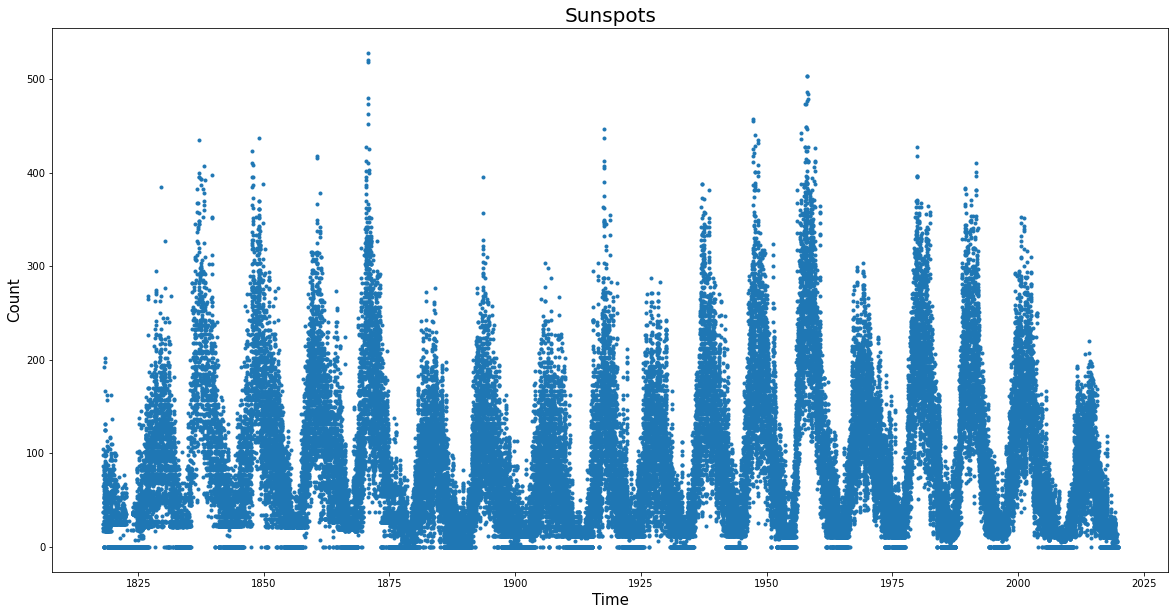

In [36]:
fig=plt.figure(figsize=(20,10))
plt.title(label = 'Sunspots', fontsize = 20)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.plot(sun_copy['date_frac'], sun_copy['sunspots'], '.')

é una serie stagionale in quanto è presente un pattern che si ripete nel tempo

#### Studio la serie senza tener conto della stagionalità

Text(0, 0.5, 'Autocorrelazione')

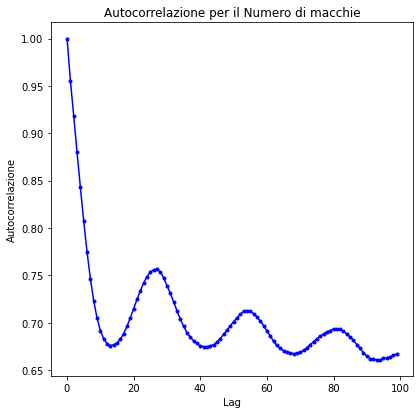

In [37]:
#autocorrelazione 
lag = range(0,100)
correlation = []
for l in lag:
    correlation.append(sun_copy['sunspots'].autocorr(l))
    
plt.figure(figsize=(6.5, 6.5))
plt.plot(correlation, marker='.', color='b')
plt.title('Autocorrelazione per il Numero di macchie')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 100)'>

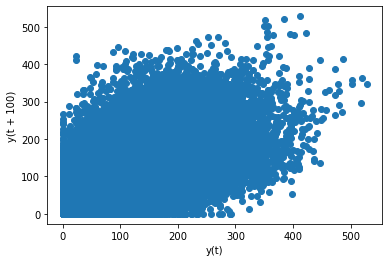

In [38]:
pd.plotting.lag_plot(sun_copy['sunspots'], lag=100)  

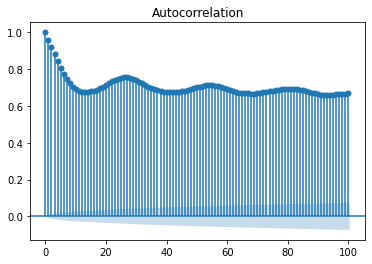

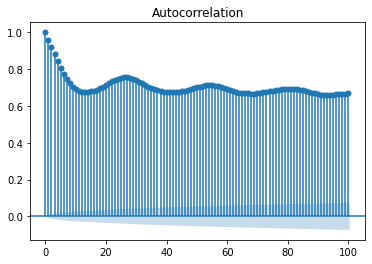

In [39]:
#autocorrelazione totale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(sun_copy['sunspots'], lags=100)

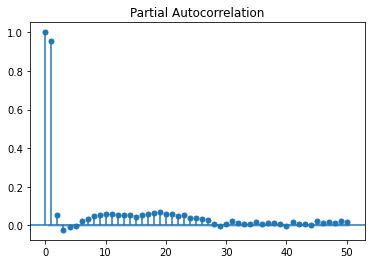

<Figure size 468x468 with 0 Axes>

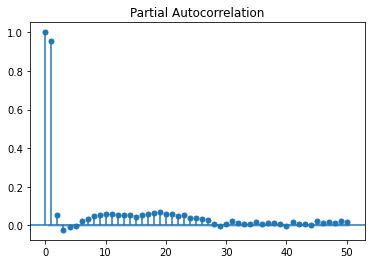

In [40]:
#autocorrelazione parziale
plt.figure(figsize=(6.5, 6.5))
plot_pacf(sun_copy['sunspots'], lags=50)

Non viene graficata la regione fiduciale nei acf e pacf plot. Quindi utilizzando i dati senza manipolazioni non posso conoscere il numero di lag da utilizzare. \ 
Vediamo comunque come si comportano la media mobile e il livellamento esponenziale nel caso in cui non si consideri la stagionalità 

##### Moving Average 


In [41]:
avg0 = sun_copy['sunspots'].rolling(2).mean() 
avg1 = sun_copy['sunspots'].rolling(3).mean()  
avg2 = sun_copy['sunspots'].rolling(7).mean()
avg3 = sun_copy['sunspots'].rolling(10).mean() 

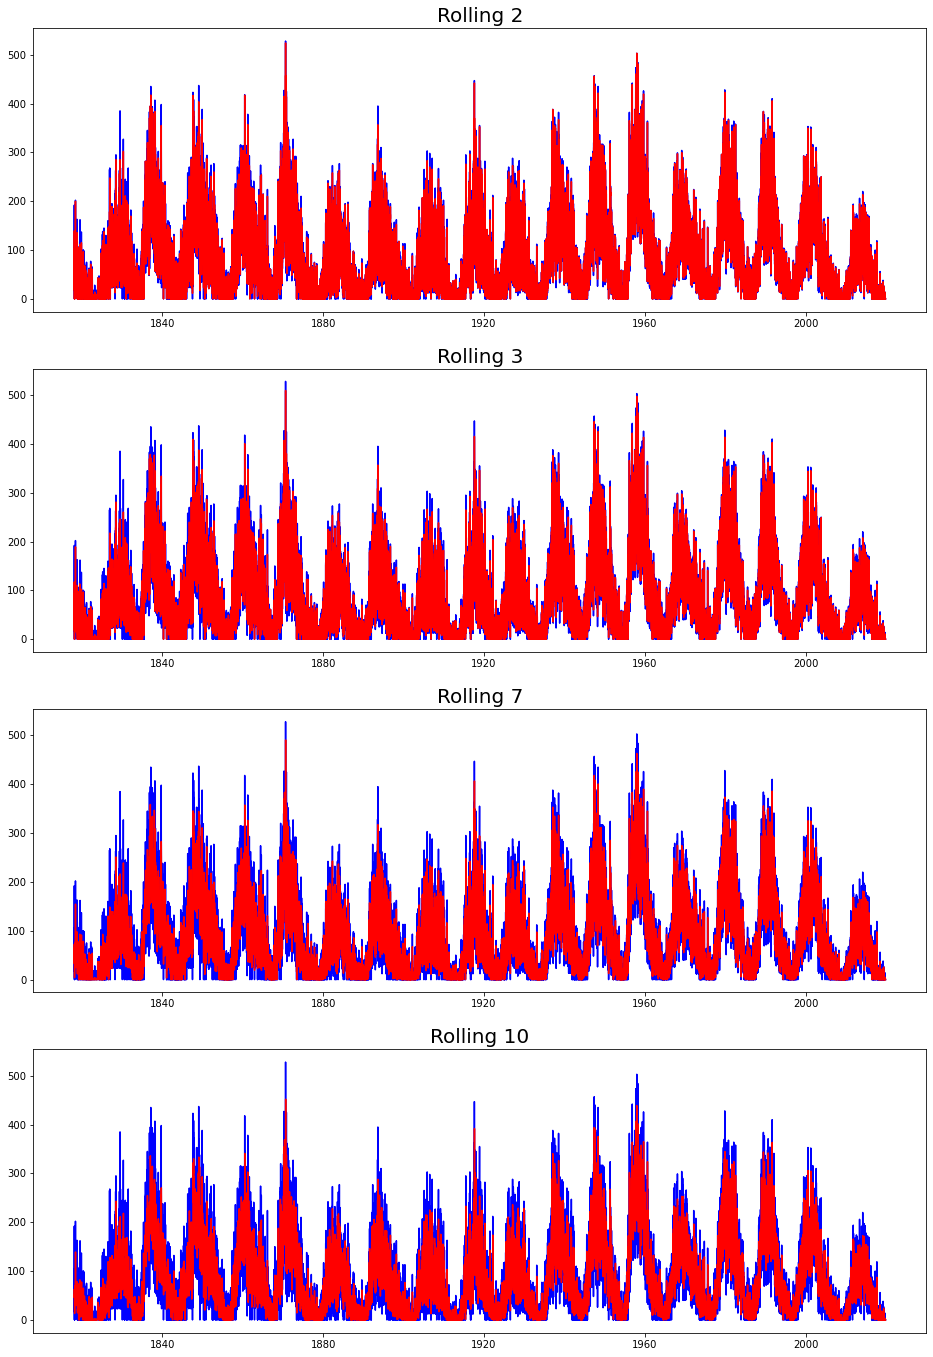

In [42]:
fig, axis = plt.subplots(4, 1, figsize=(16,24))
axis[0].set_title('Rolling 2', fontsize=20)
axis[0].plot(sun_copy['sunspots'], color='b') 
axis[0].plot(avg0, color='r')
axis[1].set_title('Rolling 3', fontsize=20)
axis[1].plot(sun_copy['sunspots'], color='b') 
axis[1].plot(avg1, color='r')
axis[2].set_title('Rolling 7', fontsize=20)
axis[2].plot(sun_copy['sunspots'], color='b') 
axis[2].plot(avg2, color='r')
axis[3].set_title('Rolling 10', fontsize=20)
axis[3].plot(sun_copy['sunspots'], color='b') 
axis[3].plot(avg3, color='r')

Si osserva che più è piccola la finestra meglio viene ricostruita la curva. Ci sono molti picchi isolati ma sembra che una dimensione della finestra uguale a 2 o 3 possa dare una buona ricostruzione. 

#### Exponential Smoothing
Poco indicato in questo caso perchè ho una serie con stagionalità e la varianza non è costante. 

In [43]:
#single smoothing
def single_smoot(serie, w):
    E = []
    E.append(serie[0])
    for i in range(1,len(serie)): 
        E.append(w*serie[i] + (1-w)*E[i-1]) 
    return E

#w=0.1
ses01 = single_smoot(sun_copy['sunspots'].values, 0.1)
#w=0.5
ses05 = single_smoot(sun_copy['sunspots'].values, 0.5)
#w=0.9
ses09 = single_smoot(sun_copy['sunspots'].values, 0.9)

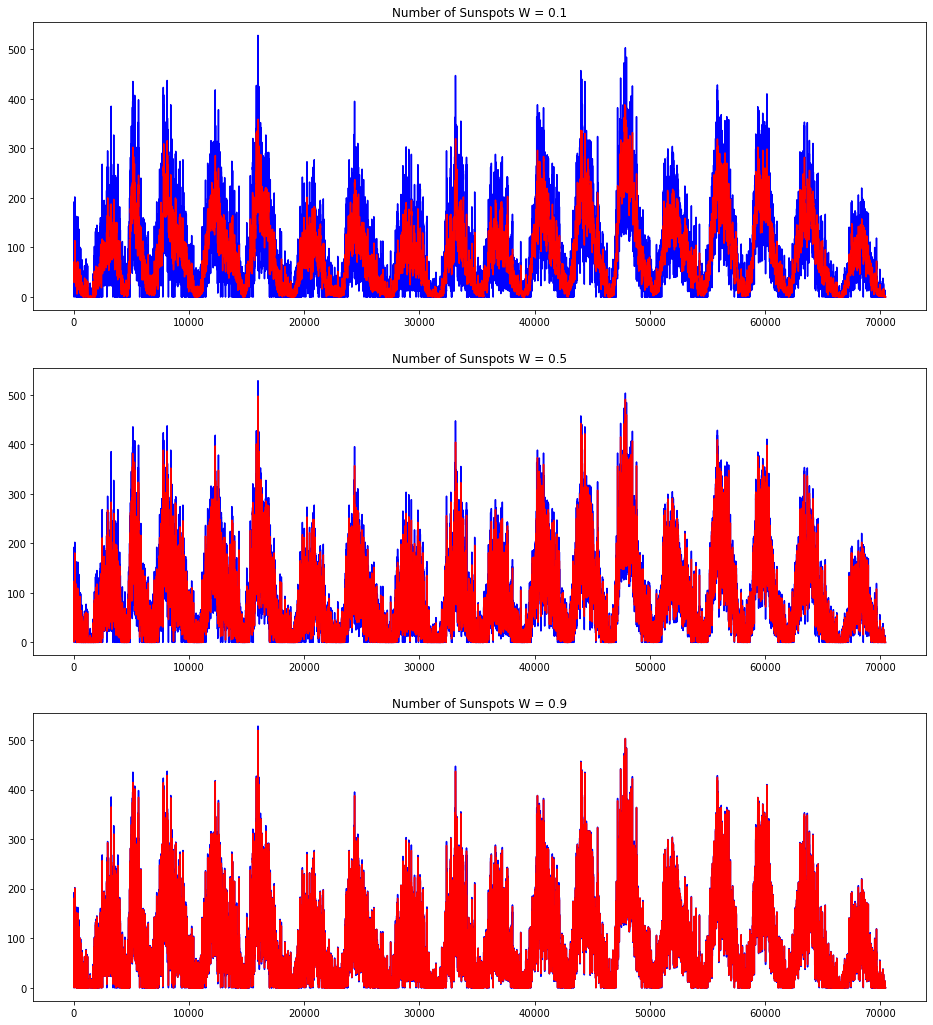

In [44]:
fig, axis = plt.subplots(3, 1, figsize=(16,18) )
axis[0].set_title('Number of Sunspots W = 0.1')
axis[0].plot(sun_copy['sunspots'].values, color='b') 
axis[0].plot(ses01, color='r')
axis[1].set_title('Number of Sunspots W = 0.5')
axis[1].plot(sun_copy['sunspots'].values, color='b') 
axis[1].plot(ses05, color='r')
axis[2].set_title('Number of Sunspots W = 0.9')
axis[2].plot(sun_copy['sunspots'].values, color='b') 
axis[2].plot(ses09, color='r')

All'aumentare di w la ricostruzione migliora

In [45]:
def double_smoot(serie, alpha, beta):
    F = [serie[0]]  #m=0    
    b = [serie[1]-serie[0]]
    s = [serie[0]]
    for i in range(1,len(serie)):
        s.append(alpha*serie[i] + (1-alpha)*(serie[i-1] + b[i-1]))
        b.append(beta*(s[i]-s[i-1]) + (1-beta)*b[i-1])
        F.append(s[i]+b[i]) #previsione di un periodo in anticipo
    return F 

des01 = double_smoot(sun_copy['sunspots'].values,0.1,0.1)
des05 = double_smoot(sun_copy['sunspots'].values,0.5,0.5)
des0105 = double_smoot(sun_copy['sunspots'].values,0.1,0.5)
des0501 = double_smoot(sun_copy['sunspots'].values,0.5,0.1)
des0801 = double_smoot(sun_copy['sunspots'].values,0.8,0.1)

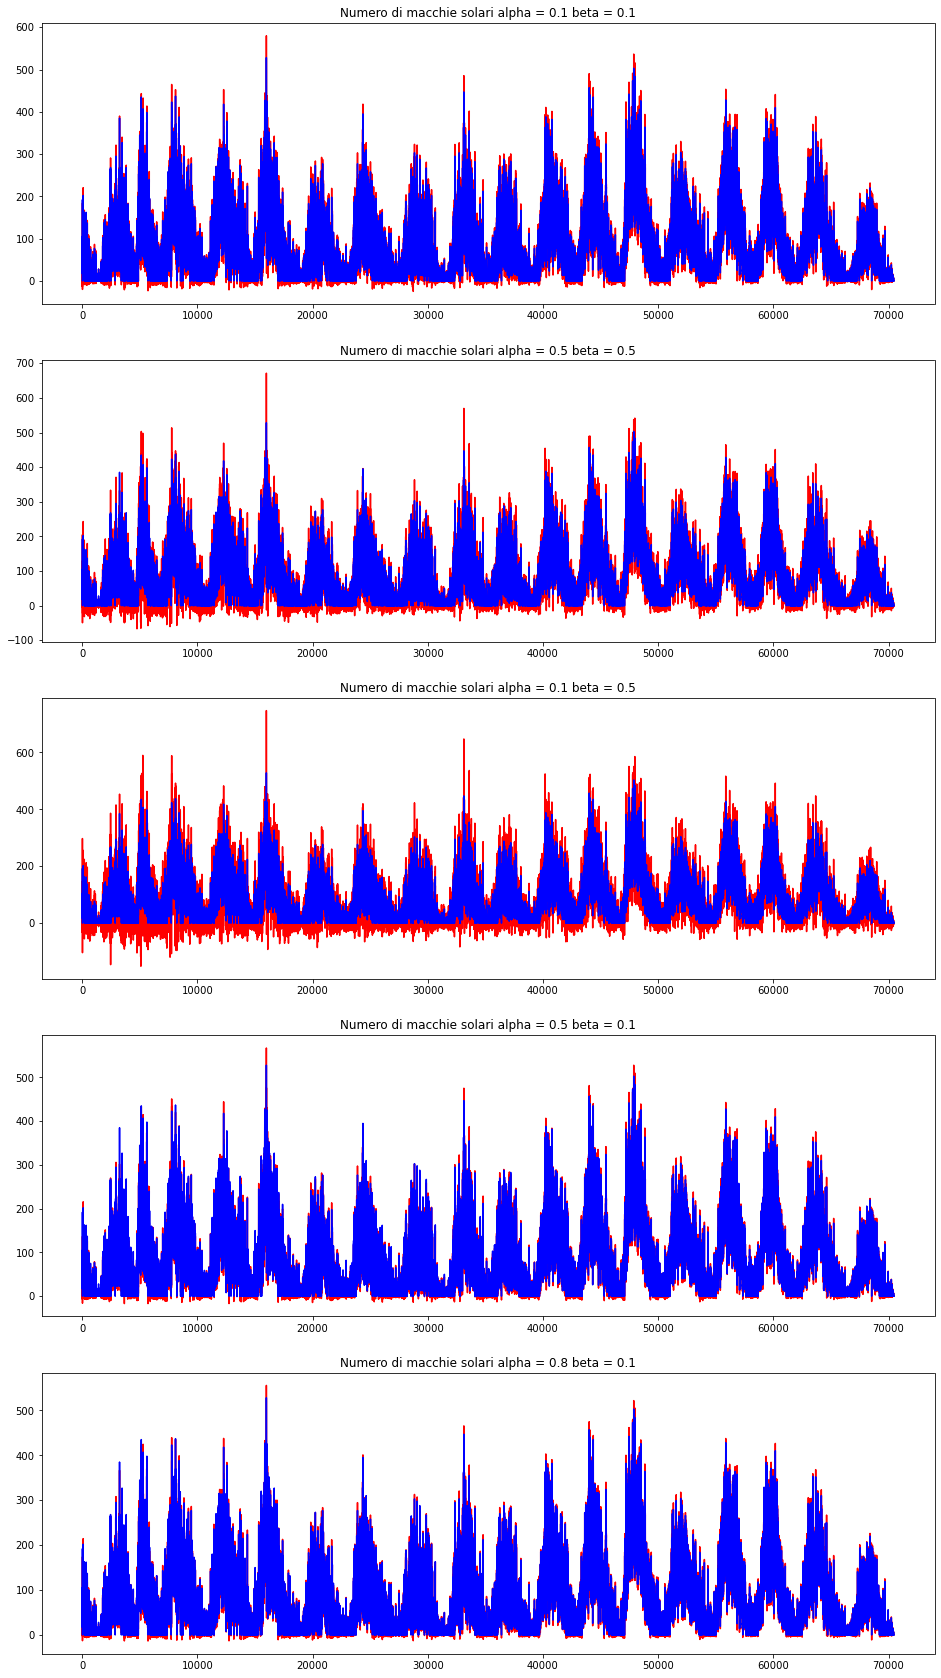

In [46]:
fig, axis = plt.subplots(5, 1, figsize=(16,30) )
axis[0].set_title('Numero di macchie solari alpha = 0.1 beta = 0.1')
axis[0].plot(des01, color='r')
axis[0].plot(sun_copy['sunspots'].values, color='b') 
axis[1].set_title('Numero di macchie solari alpha = 0.5 beta = 0.5')
axis[1].plot(des05, color='r')
axis[1].plot(sun_copy['sunspots'].values, color='b') 
axis[2].set_title('Numero di macchie solari alpha = 0.1 beta = 0.5')
axis[2].plot(des0105, color='r')
axis[2].plot(sun_copy['sunspots'].values, color='b') 
axis[3].set_title('Numero di macchie solari alpha = 0.5 beta = 0.1')
axis[3].plot(des0501, color='r')
axis[3].plot(sun_copy['sunspots'].values, color='b') 
axis[4].set_title('Numero di macchie solari alpha = 0.8 beta = 0.1')
axis[4].plot(des0801, color='r')
axis[4].plot(sun_copy['sunspots'].values, color='b') 

Aumentando il parametro beta la ricostruzione peggiora, aumentando alpha migliora. Ho variato i valori di alpha tra 0.5 e 0.9 e non si osserva un sostanziale cambiamento. Quindi un buon compromesso potrebbe essere $\alpha = 0.8$ e $\beta = 0.1$

## Previsione Numero di macchie 

Eseguendo l'autocorrelazione sull'intero set di dati non si riesce a trovare l'ordine p da utilizzare e non si evidenzia la regione fiduciale. Questo può essere dovuto al fatto che i dati presentano una certa stagionalità. Provo a ricampionare il dataframe effettuando un Downsampling, ovvero riduco la frequenza dei campioni. \
https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

Calcolo il valore ricampionato come il numero medio (.mean()) di macchie solari per il trimestre ('Q'). \
Tabella frequenze a questo link: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [47]:
sunspot_series = pd.Series(data=sun_copy.sunspots, index=sun_copy.index)
resample = sunspot_series.resample('Q').mean()

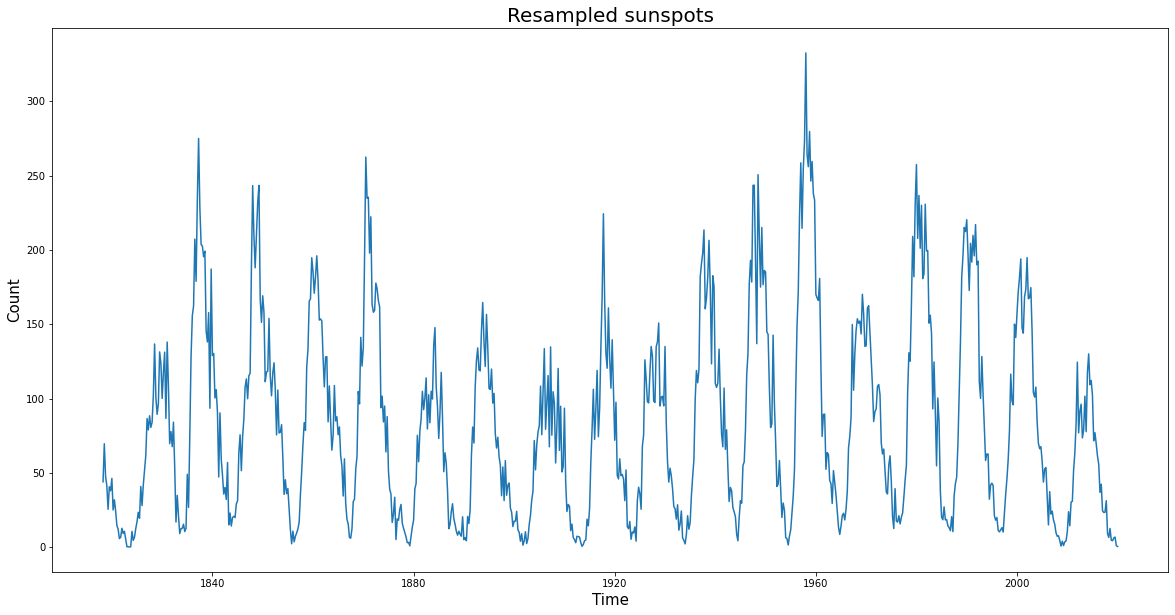

In [48]:
fig=plt.figure(figsize=(20,10))
plt.title(label = 'Resampled sunspots', fontsize = 20)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.plot(resample)

Text(0, 0.5, 'Autocorrelazione')

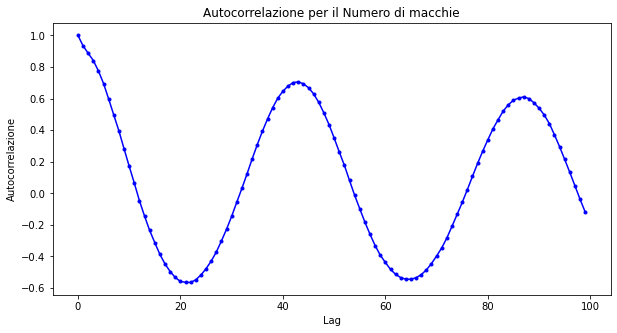

In [49]:
#autocorrelazione 
lag = range(0,100)
correlation = []
for l in lag:
    correlation.append(resample.autocorr(l))
    
plt.figure(figsize=(10, 5))
plt.plot(correlation, marker='.', color='b')
plt.title('Autocorrelazione per il Numero di macchie')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 100)'>

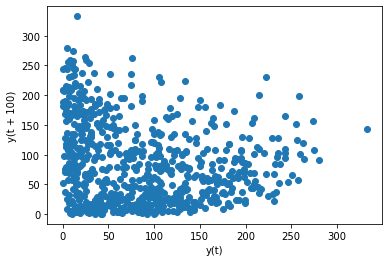

In [50]:
pd.plotting.lag_plot(resample, lag=100)  

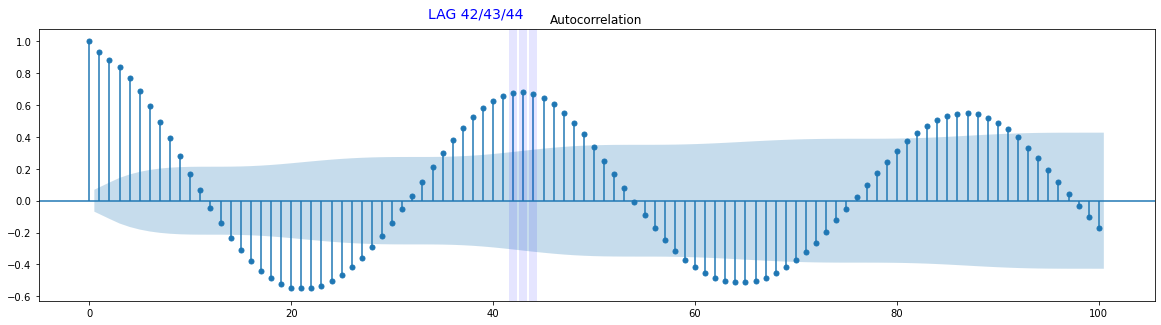

In [51]:
#autocorrelazione totale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax1 = plt.subplots( 1, 1, figsize=(20,5) )
# Vertical lines
[ax1.axvline(lag, color = "blue", lw = 8, alpha = 0.1) for lag in range(42,45)]
#ax1.axvline(6, color = "red", lw = 10, alpha = 0.1)

# Text
#ax1.text(6, 1.15, "LAG6", horizontalalignment='center', fontsize=14, color="red")
ax1.text(43, 1.15, "LAG 42/43/44", horizontalalignment='right', fontsize=14, color="blue")
plot_acf(resample, ax = ax1, lags=100)
plt.show()

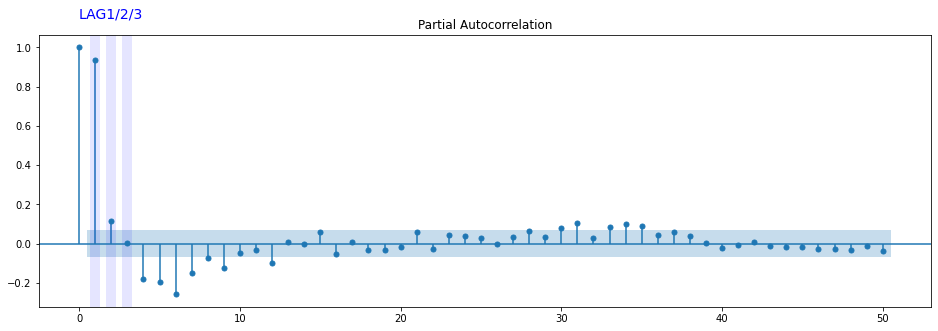

In [52]:
#autocorrelazione parziale
fig, ax1 = plt.subplots( 1, 1, figsize=(16,5))

# Vertical lines
[ax1.axvline(lag, color = "blue", lw = 10, alpha = 0.1) for lag in range(1,4)]
#ax1.axvline(6, color = "red", lw = 10, alpha = 0.1)

# Text
#ax1.text(6, 1.15, "LAG6", horizontalalignment='center', fontsize=14, color="red")
ax1.text(2, 1.15, "LAG1/2/3", horizontalalignment='center', fontsize=14, color="blue")

plot_pacf(resample, ax=ax1, lags=50)
plt.show()

Trovo che p=2. \  
Eseguendo un downsampling riesco a visualizzare la correlazione e la regione fiduciale. Le serie stagionali è meglio modellizzarle con SARIMA, ovvero ARIMA nel caso di stagionalità. https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  \
Per trovare gli iperparametri da utilizzare nel modello si possono utilizzare delle Grid Search SARIMA Hyperparameters. https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

#### Moving Average 


In [53]:
avg0_r = resample.rolling(2).mean() 
avg1_r = resample.rolling(3).mean()  
avg2_r = resample.rolling(6).mean() 

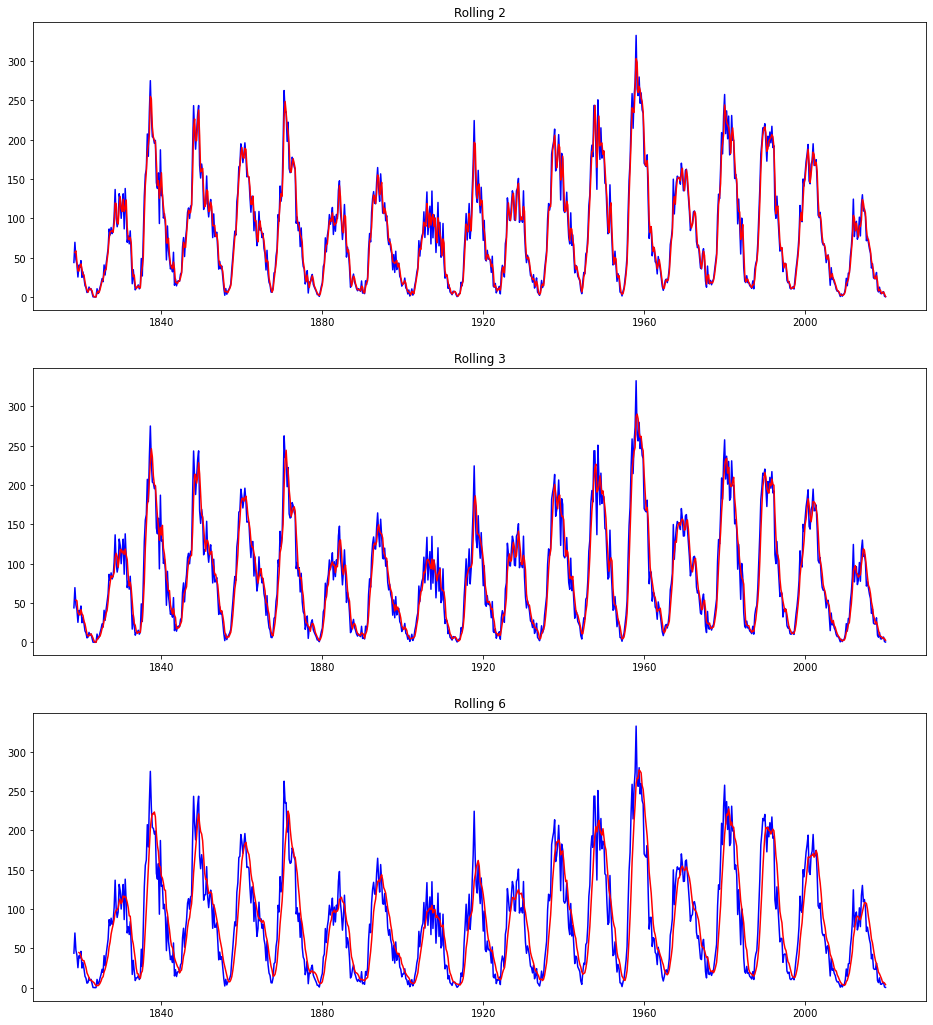

In [54]:
fig, axis = plt.subplots(3, 1, figsize=(16,18))
axis[0].set_title('Rolling 2')
axis[0].plot(resample, color='b') 
axis[0].plot(avg0_r, color='r')
axis[1].set_title('Rolling 3')
axis[1].plot(resample, color='b') 
axis[1].plot(avg1_r, color='r')
axis[2].set_title('Rolling 6')
axis[2].plot(resample, color='b') 
axis[2].plot(avg2_r, color='r')

Con dimensione della finestra uguale a 2 si ottiene la ricostruzione migliore

#### Exponential Smoothing
Poco indicato in questo caso perchè ho una serie con stagionalità e la varianza non è costante. 

In [55]:
#w=0.1
ses01_r = single_smoot(resample.values, 0.1)
#w=0.5
ses05_r = single_smoot(resample.values, 0.5)
#w=0.9
ses09_r = single_smoot(resample.values, 0.9)

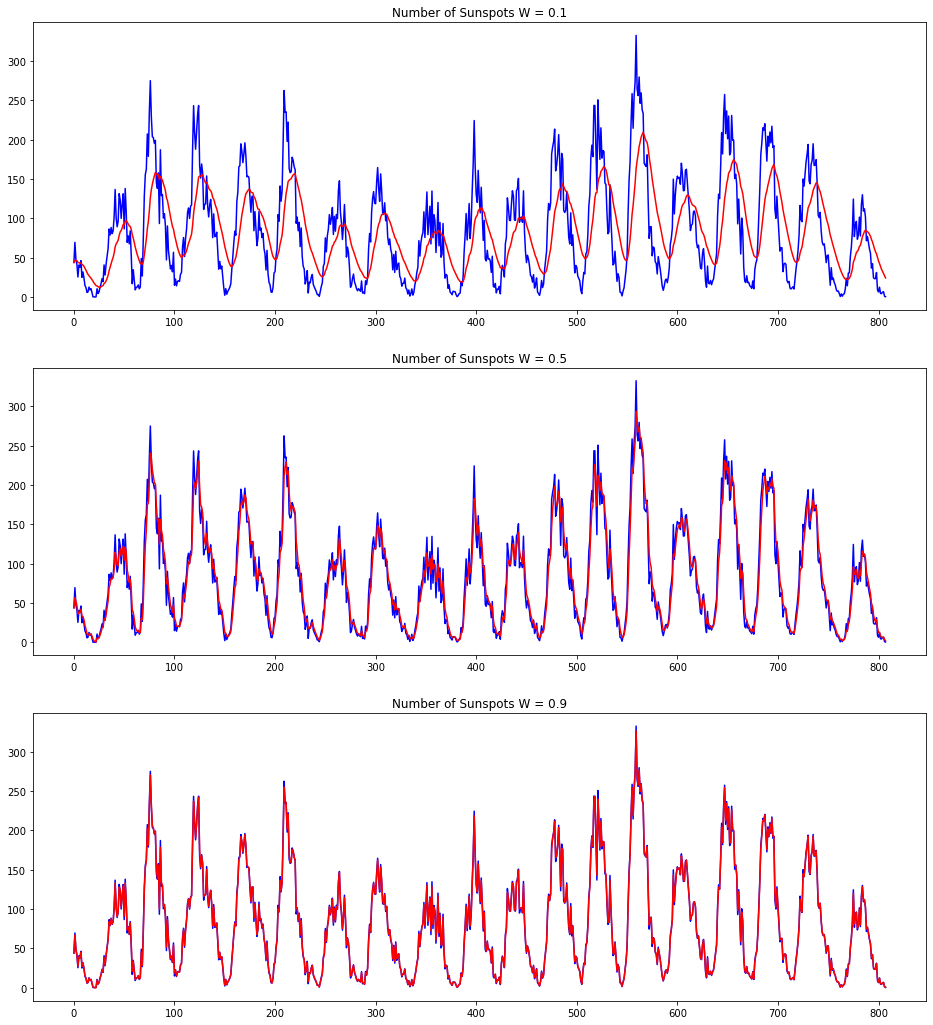

In [56]:
fig, axis = plt.subplots(3, 1, figsize=(16,18) )
axis[0].set_title('Number of Sunspots W = 0.1')
axis[0].plot(resample.values, color='b') 
axis[0].plot(ses01_r, color='r')
axis[1].set_title('Number of Sunspots W = 0.5')
axis[1].plot(resample.values, color='b') 
axis[1].plot(ses05_r, color='r')
axis[2].set_title('Number of Sunspots W = 0.9')
axis[2].plot(resample.values, color='b') 
axis[2].plot(ses09_r, color='r')

w = 0.9

In [57]:
des01_r = double_smoot(resample.values,0.1,0.1)
des05_r = double_smoot(resample.values,0.5,0.5)
des0801_r = double_smoot(resample.values,0.8,0.1)

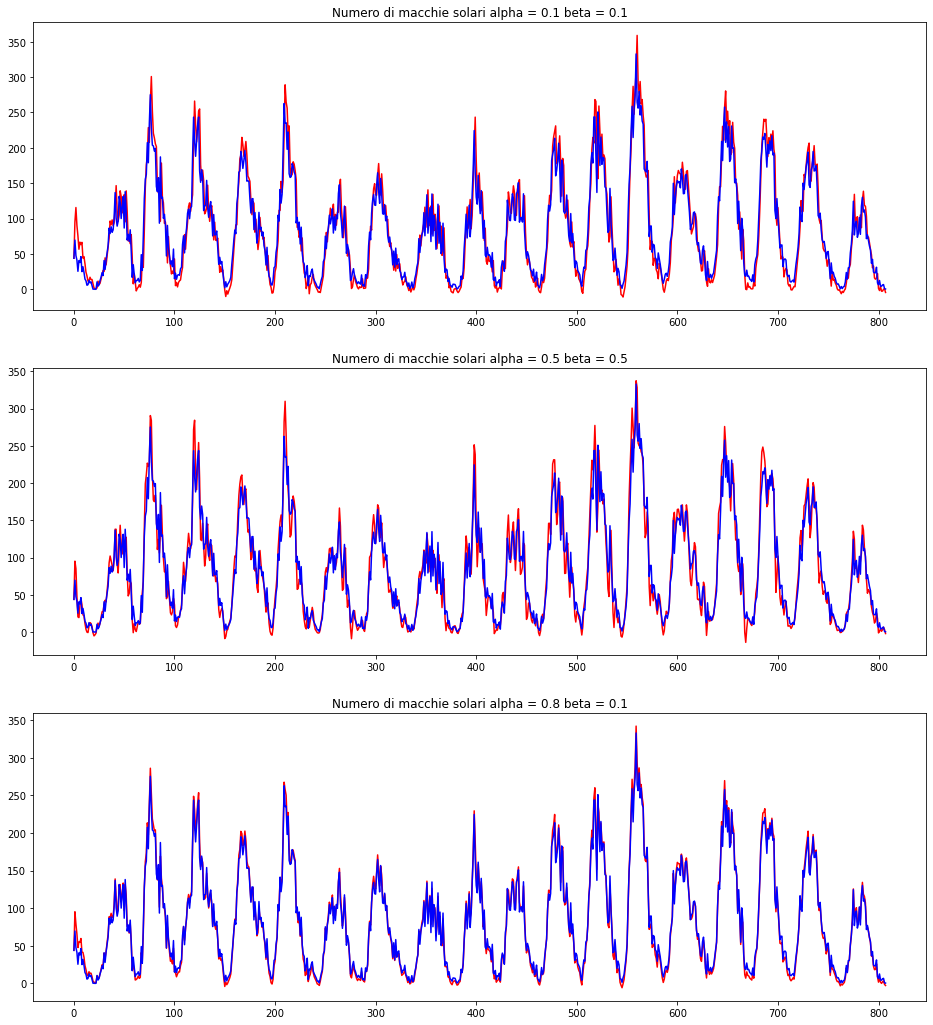

In [58]:
fig, axis = plt.subplots(3, 1, figsize=(16,18) )
axis[0].set_title('Numero di macchie solari alpha = 0.1 beta = 0.1')
axis[0].plot(des01_r, color='r')
axis[0].plot(resample.values, color='b') 
axis[1].set_title('Numero di macchie solari alpha = 0.5 beta = 0.5')
axis[1].plot(des05_r, color='r')
axis[1].plot(resample.values, color='b') 
axis[2].set_title('Numero di macchie solari alpha = 0.8 beta = 0.1')
axis[2].plot(des0801_r, color='r')
axis[2].plot(resample.values, color='b') 

Valgono le stesse considerazioni del caso non ricampionato

#### Modello ARIMA  

Utilizzo ARIMA quando ho una serie non stazionaria e non stagionale. Mi aspetto quindi che non riesca a predirre bene l'andamento delle macchie solari essendoci stagionalità. \
In base agli studi effettuati fino ad ora utilizzo p=2 e q=2.

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import DataFrame
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [60]:
#Creo un dataframe per testare il modello ARIMA
df=sun_copy[['sunspots']].copy()
df.shape

(70471, 1)

In [61]:
#ricampiono come prima, dove S considera l'inzio del quadrimestre 
resample_q = df.resample('QS').mean()
resample_q.shape

(808, 1)

In [62]:
def arima_model_sunspot(data, time_split, time_end_test, p, d, q, offset): 
    
    #divido il dataset in train e test
    train = data[data.index <= time_split]
    test1 = data[data.index > time_split] 
    test = test1[test1.index < time_end_test]
    print(train.shape, test.shape)
    
    #grafico train e test
    fig, ax1 = plt.subplots(1, 1, figsize=(16,6))
    train.plot(color = 'r', label = "train", ax = ax1)
    test.plot(color = 'g', lw = 3, label = "test", ax = ax1)
    ax1.set_ylabel("OBSERVED SUNSPOTS"); ax1.set_xlabel("YEAR")
    plt.legend(); plt.show()
    
    # evaluate an ARIMA model using a walk-forward validation
    history = [x for x in train.values]
    predictions = list()
    # walk-forward validation
    for t in range(len(test.values)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(test.values[t])
        
    predict_serie = pd.Series(data= predictions, index=test.index)
    
    #evaluate forecasts
    rmse = sqrt(mean_squared_error(test.values, predictions))
    print('Test RMSE: %.3f' % rmse)
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    test.sunspots.plot(ax = ax1, color = "b", lw = 2, label = "Test")
    predict_serie.plot(ax = ax1, color='red', label = "Prediction")
    plt.legend()
    ax1.xaxis.grid()
    
    
    #grafico train, test e predizione
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
    train.sunspots[offset:].plot(ax = ax1, color = "g", lw = 3, label = "Train")
    test.sunspots.plot(ax = ax1, color = "y", lw = 3, label = "Test")
    predict_serie.plot(ax = ax1, color = "r", lw = 2, label = "In-Sample Prediction") 
    ax1.set_xlabel("Time"); ax1.set_ylabel("Sunspots"); plt.legend()
    ax1.xaxis.grid()
    
    #line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())
    
    return model, train, test, model_fit, predict_serie

def predict_future(data, model_trained, future_steps, train, test, p, d, q, offset, predict_serie):
    #history1 = [x for x in data.values]
    history1 = [x for x in train.values] + [x for x in test.values]
    history1 = history1[-43:] #-43
    for t in range(future_steps):
        model_trained = ARIMA(history1, order=(p,d,q))
        model_fit = model_trained.fit()
        output = model_fit.forecast()
        history1.append(output)
    
    time = pd.Series(pd.period_range(test.index[-1].strftime("%Y-%m-%d"), freq="Q", periods=future_steps)) #-1
    times = [i.strftime("%Y-%m-%d") for i in time] 
    dates = [datetime.strptime(x,"%Y-%m-%d") for x in times]
    predict_serie_out = pd.DataFrame(history1[-future_steps:], columns=['sunspots'], index = dates)
    predict_serie_out.plot(figsize=(16, 6))
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
    data.sunspots[test.index[-1]:].plot(ax = ax1, color = "g", lw = 3, label = "data")
    train.sunspots[offset:].plot(ax = ax1, color = "g", lw = 3, label = "Train")
    test.sunspots.plot(ax = ax1, color = "y", lw = 3, label = "Test")
    predict_serie.plot(ax = ax1, color = "r", lw = 2, label = "In-Sample Prediction")
    predict_serie_out.plot(ax = ax1, color = "b", lw = 3, label = "Out-Of-Sample Prediction") 
    ax1.set_xlabel("Time"); ax1.set_ylabel("Sunspots"); plt.legend()
    ax1.xaxis.grid()
    
    #line plot of residuals
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())
    
    return predict_serie_out

Per predirre utilizzando ARIMA l'andamento di una serie stagionale è necessaria una previsione progressiva data la dipendenza dalle osservazioni nelle fasi temporali precedenti per il differencing e il modello AR. Un modo approssimativo per eseguire questa previsione mobile è ricreare il modello ARIMA dopo aver ricevuto ogni nuova osservazione.

(725, 1) (39, 1)


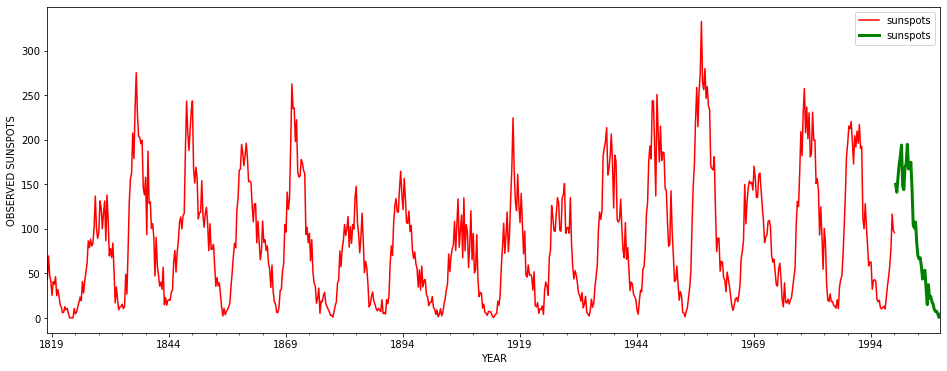

Test RMSE: 18.687


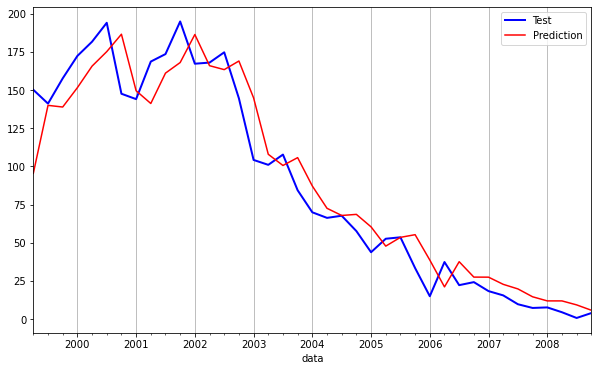

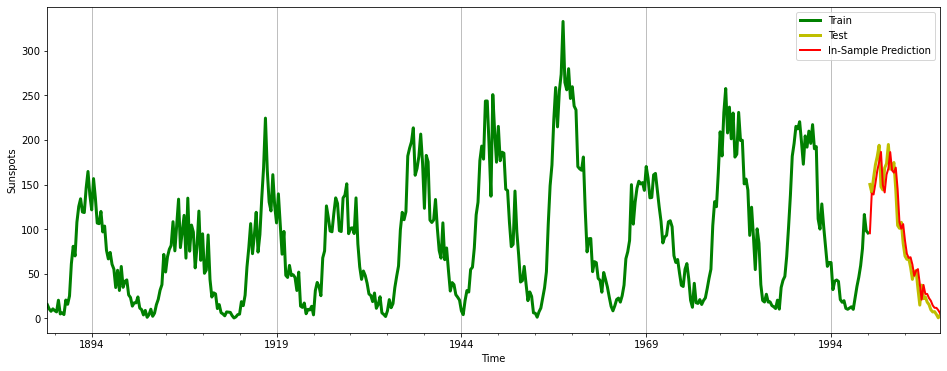

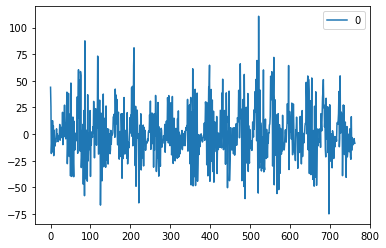

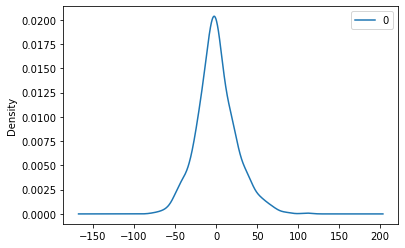

                0
count  763.000000
mean     0.540947
std     24.091683
min    -74.877604
25%    -14.126089
50%     -0.903146
75%     14.217644
max    110.574698


In [63]:
#train 1999 test 99-2009 
arima_model, train, test, model_fit, predict_serie = arima_model_sunspot(resample_q, "1999-01-01", "2009-01-01", 2, 1, 2, 70*4)

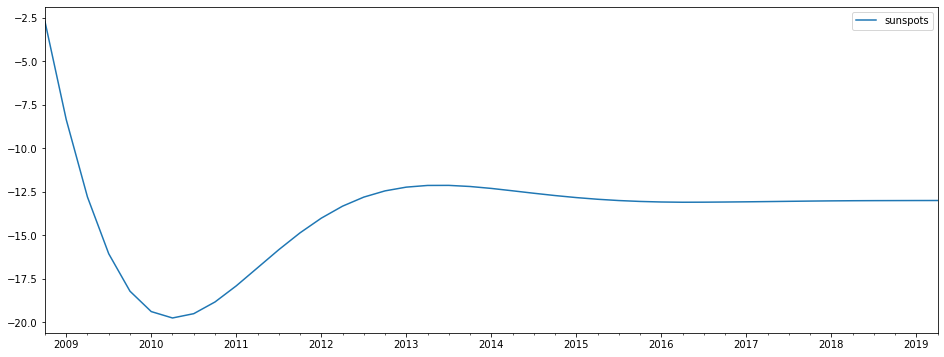

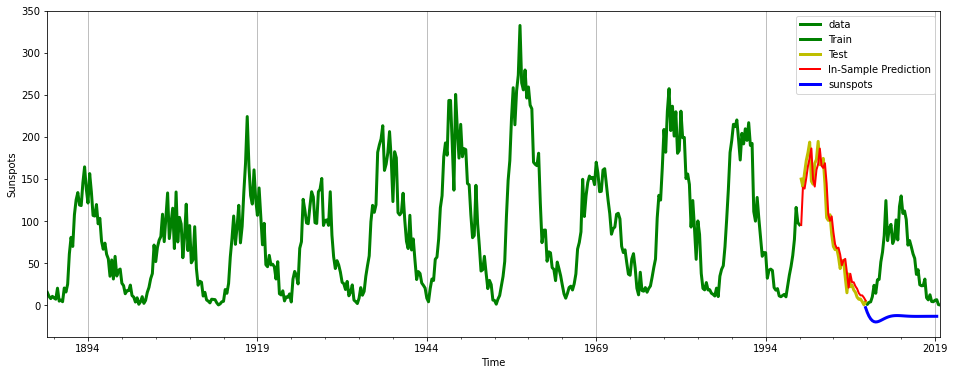

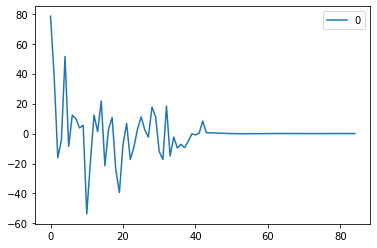

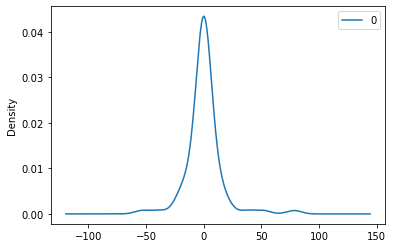

               0
count  85.000000
mean    0.319905
std    15.375902
min   -53.651437
25%    -0.223060
50%     0.000524
75%     0.504938
max    78.318681


In [64]:
predict_serie_out_212 = predict_future(resample_q, arima_model, 43, train, test, 2, 1, 2, 70*4, predict_serie)

<AxesSubplot:xlabel='data'>

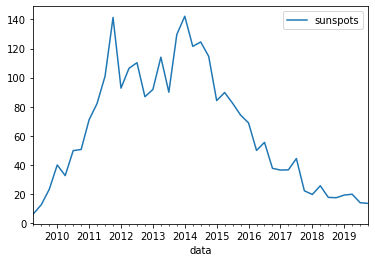

In [65]:
a = resample_q[-43:] 
res = a.sub(predict_serie_out_212.values)
res.plot()

Confronto il risultato ottenuto con quello che ottengo usando get_prediction

<AxesSubplot:>

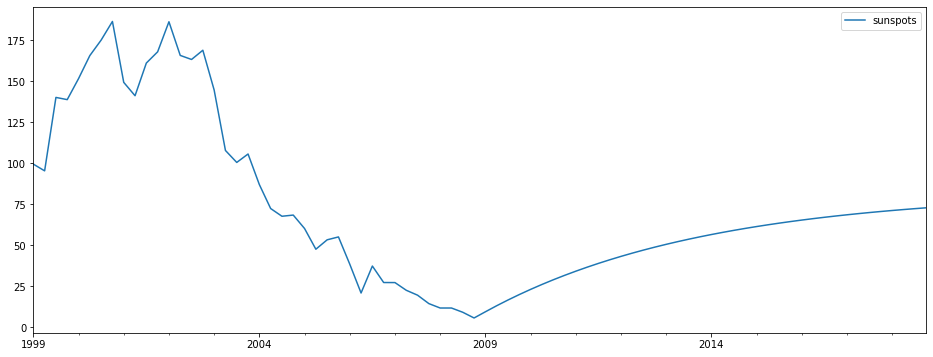

In [66]:
from datetime import datetime
pred_out = model_fit.get_prediction(start=len(train)-1, end=len(train)-2 + 80) 
time = pd.Series(pd.period_range(train.index[-1].strftime("%Y-%m-%d"), freq="Q", periods=80))
times = [i.strftime("%Y-%m-%d") for i in time] 
dates = [datetime.strptime(x,"%Y-%m-%d") for x in times]
predict_serie_out = pd.DataFrame(pred_out.predicted_mean, columns=['sunspots'], index=dates)
predict_serie_out.plot(figsize=(16, 6))

#### Ricampiono per anno per confrontare i risultati con i quadrimestri

In [67]:
resample_y = df.resample('Y').mean()
resample_y.shape

(202, 1)

(181, 1) (10, 1)


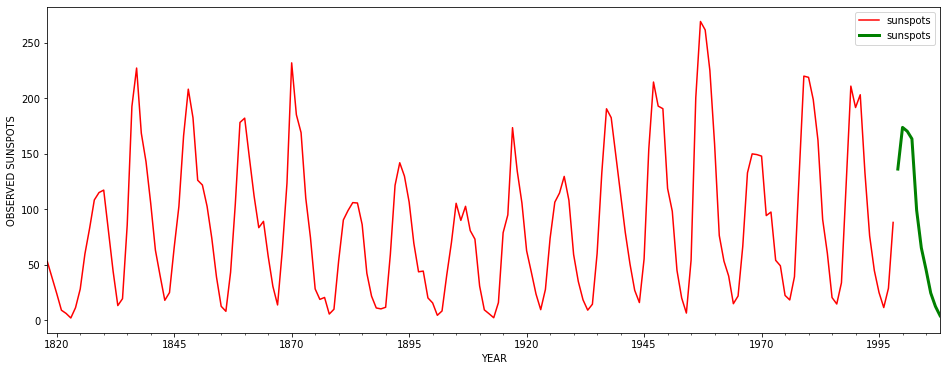

Test RMSE: 18.206


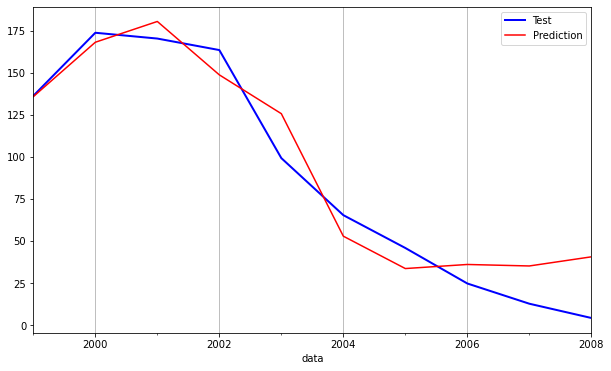

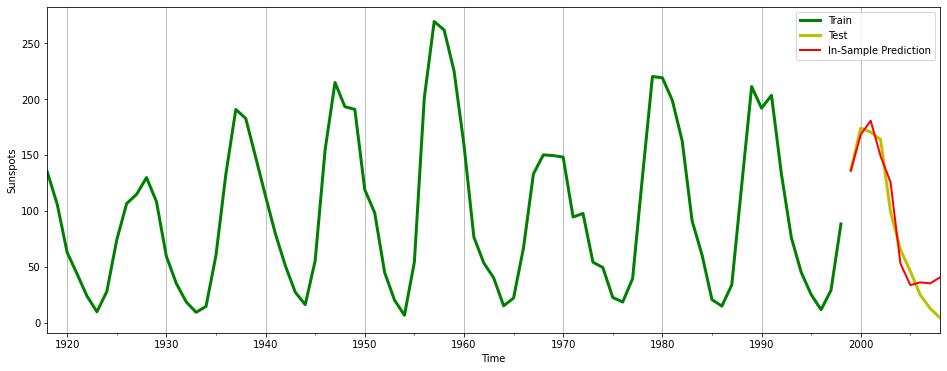

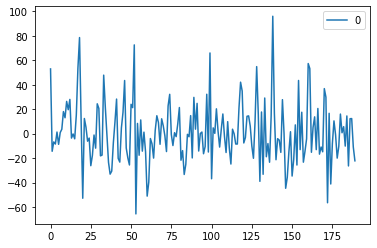

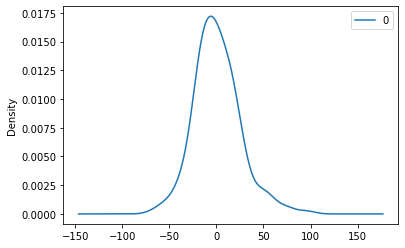

                0
count  190.000000
mean     0.851164
std     24.738282
min    -65.695927
25%    -14.909214
50%     -0.734723
75%     14.697768
max     96.041474


In [68]:
arima_model_y, train_y, test_y, _, predict_serie = arima_model_sunspot(resample_y, "1999-01-01", "2009-01-01", 2, 1, 2, 100)

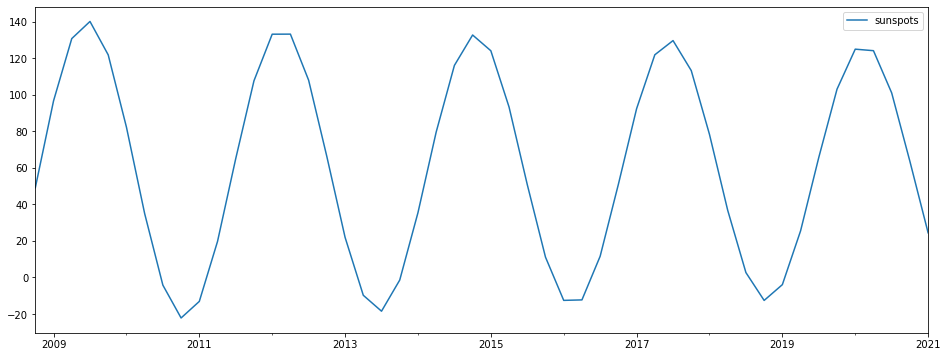

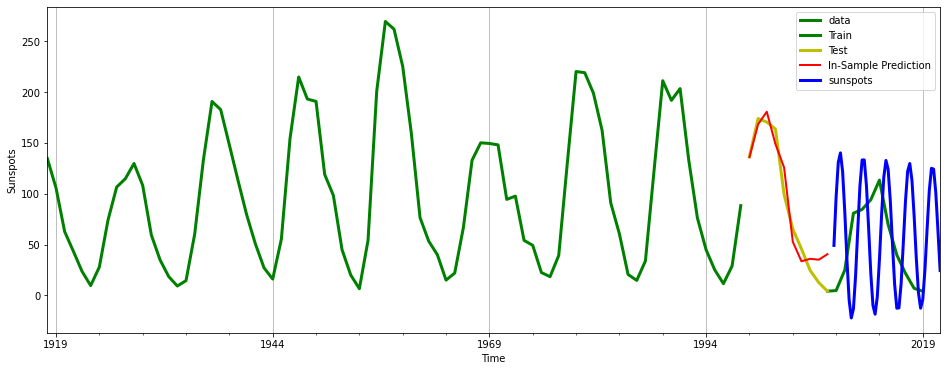

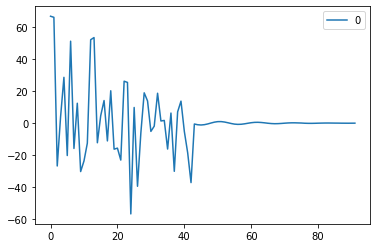

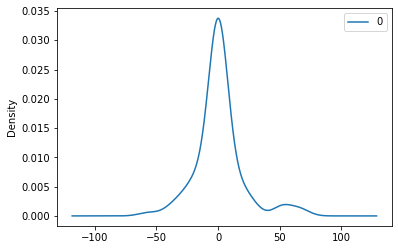

               0
count  92.000000
mean    0.987007
std    19.107983
min   -56.681459
25%    -0.961815
50%    -0.022945
75%     0.948791
max    66.756164


In [69]:
_ = predict_future(resample_y, arima_model_y, 50, train_y, test_y, 2, 1, 2, 100, predict_serie)

La predizione ha un andamento simile al caso precedente in cui ho considerato un ricampionamento sui quadrimestri. Tuttavia il valor medio dei residui indica che la predizione è meno buona in questo caso. Infatti prima res_mean = 0.020 e ora = 0.37

In base a quanto detto, continuerò a utilizzare il ricampionamento sui quadrimestri per eseguire i test riguardanti il numero di parametri p, d, q ottimali.

#### p = 2 d = 2 q = 2 

(725, 1) (39, 1)


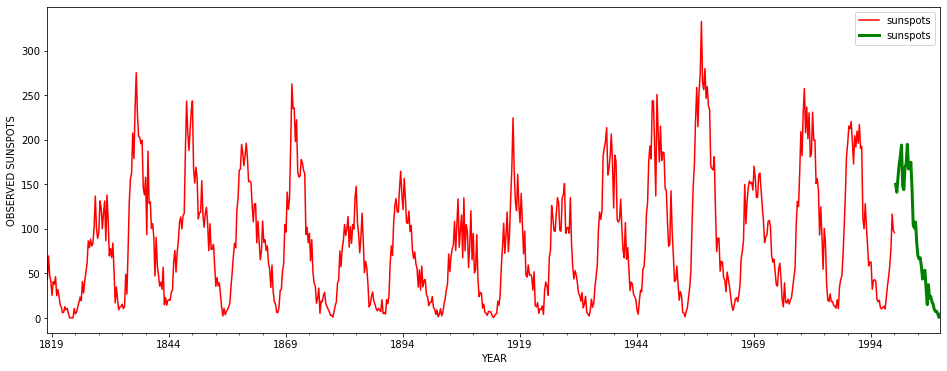

Test RMSE: 17.711


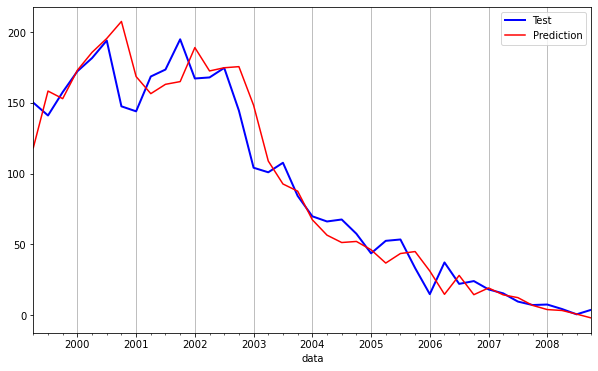

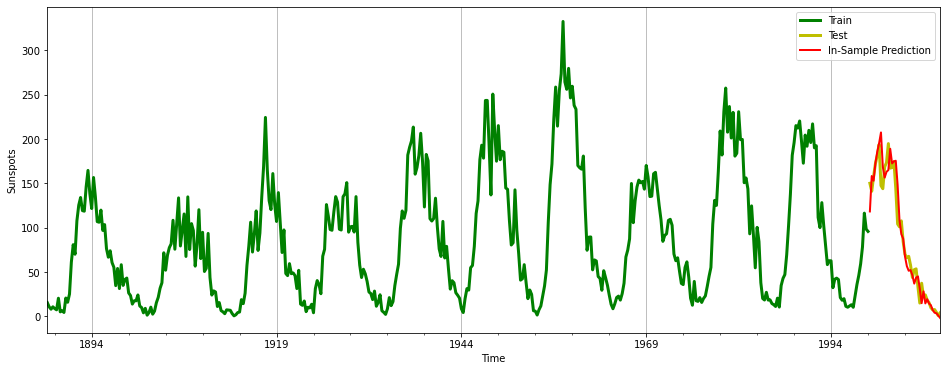

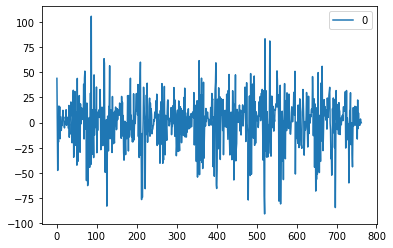

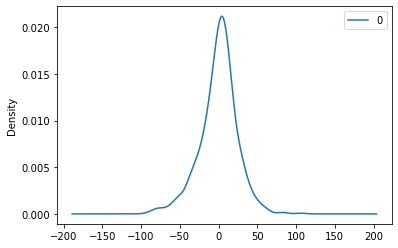

                0
count  763.000000
mean    -0.011972
std     24.188018
min    -90.709673
25%    -12.297187
50%      2.068096
75%     13.494897
max    105.645485


In [70]:
arima_model_1, train_1, test_1, _, predict_serie = arima_model_sunspot(resample_q, "1999-01-01", "2009-01-01", 2, 2, 2, 70*4)

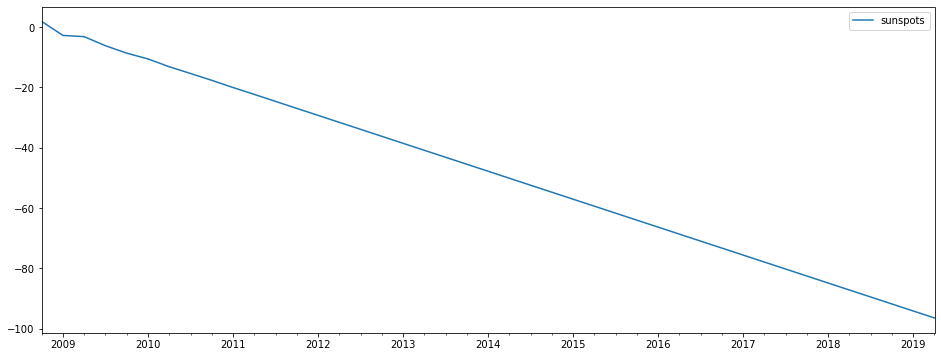

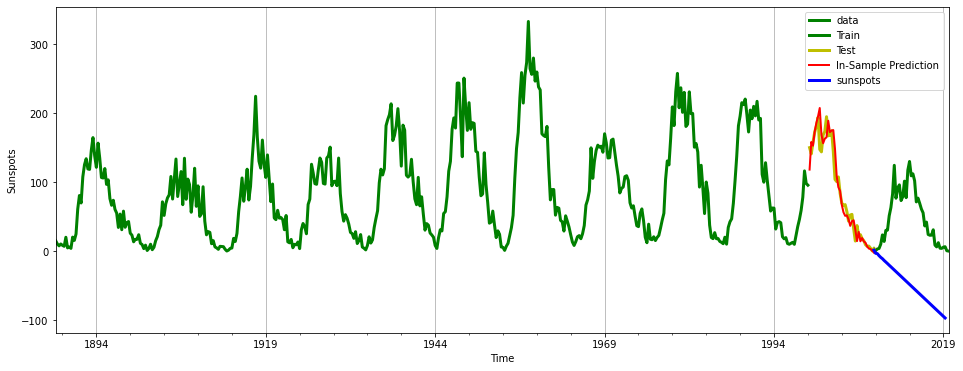

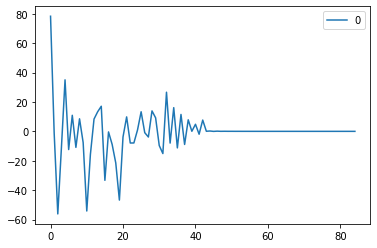

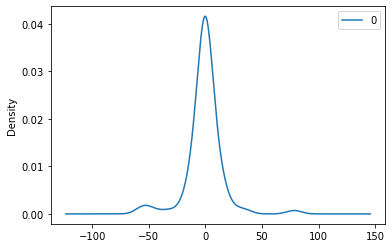

               0
count  85.000000
mean   -0.769081
std    15.896597
min   -56.178288
25%    -1.054480
50%     0.000341
75%     0.054354
max    78.318681


In [71]:
_ = predict_future(resample_q, arima_model_1, 43, train_1, test_1, 2, 2, 2, 70*4, predict_serie)

d=2 non va bene. 
#### p = 3 d=1 q =2

(725, 1) (39, 1)


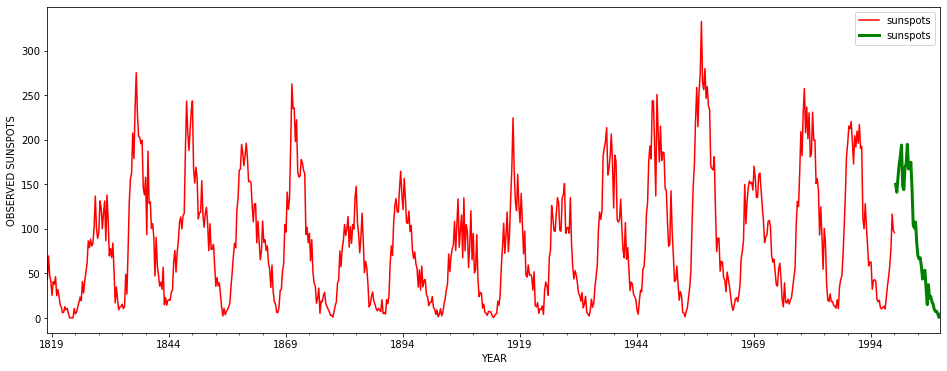

C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 17.401


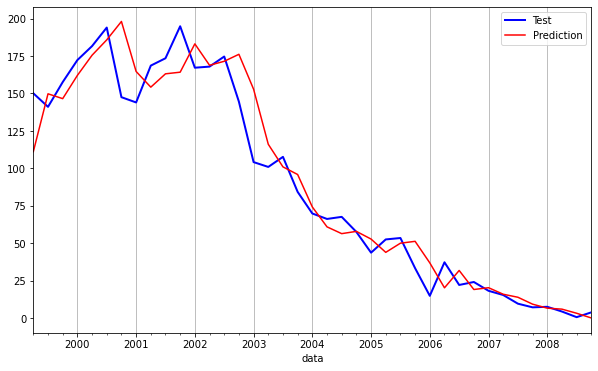

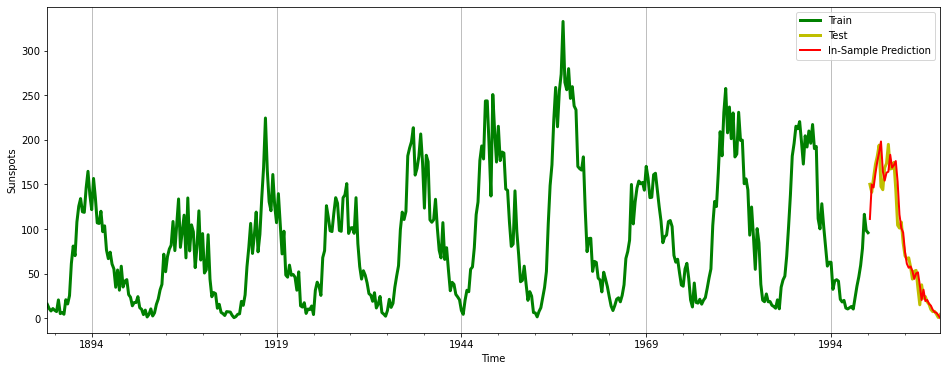

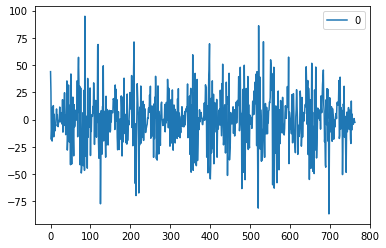

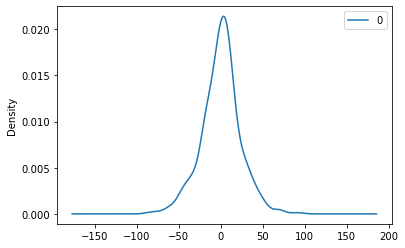

                0
count  763.000000
mean     0.017698
std     23.242672
min    -86.551257
25%    -13.039157
50%      1.213213
75%     11.883326
max     94.755276


In [72]:
arima_model_2, train_2, test_2, _, predict_serie = arima_model_sunspot(resample_q, "1999-01-01", "2009-01-01", 3, 1, 2, 70*4)

C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


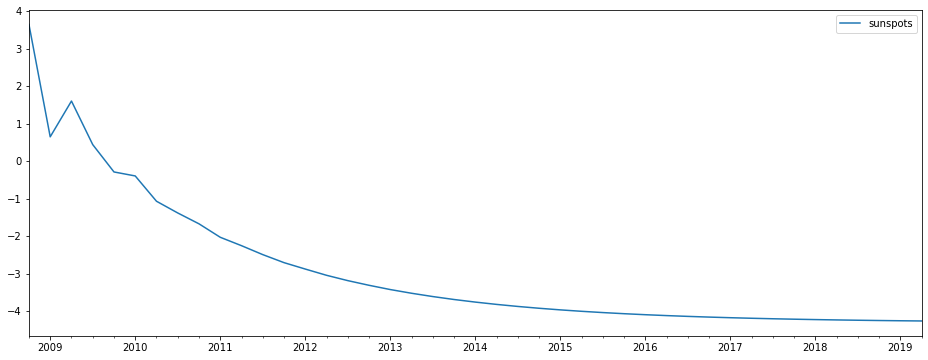

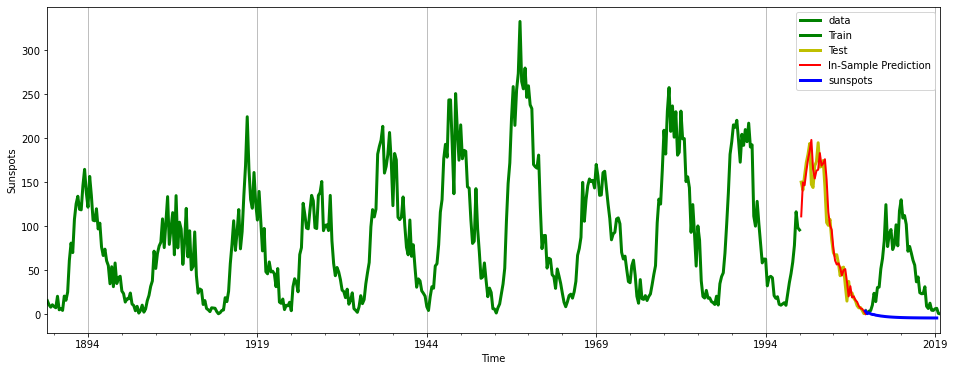

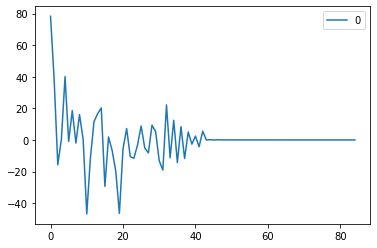

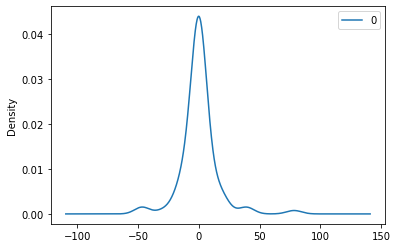

               0
count  85.000000
mean    0.346465
std    15.072124
min   -46.837123
25%    -0.928464
50%     0.001521
75%     0.170139
max    78.318681


In [73]:
_ = predict_future(resample_q, arima_model_2, 43, train_2, test_2, 3, 1, 2, 70*4, predict_serie)

Si osserva un lieve cambiamento nella predizione rispetto al caso in cui p = 2. L'errore è superiore ma in maniera non significativa (di 0.001) 
#### p=2 d=1 q =1 

(725, 1) (39, 1)


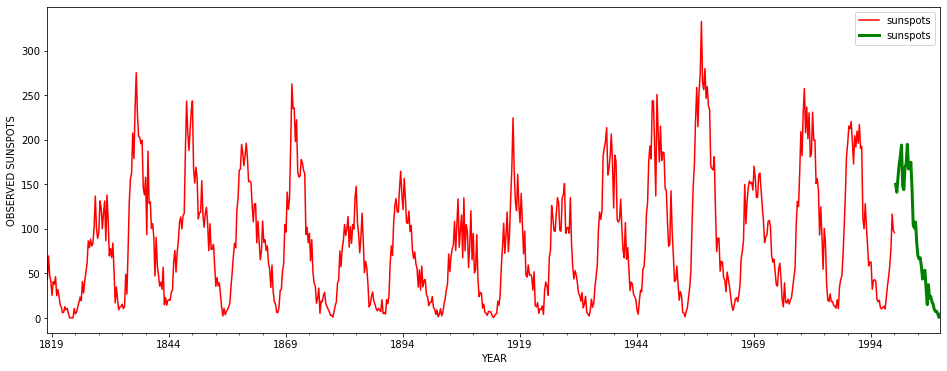

C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 18.328


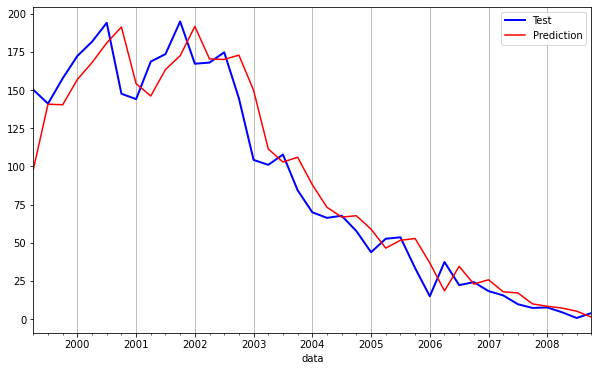

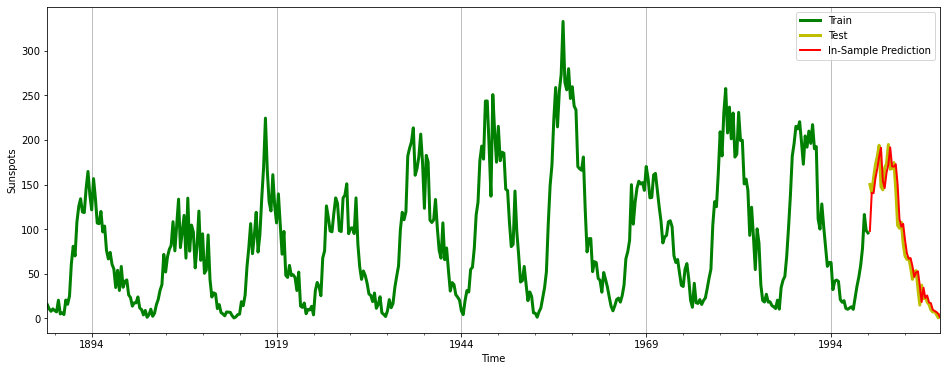

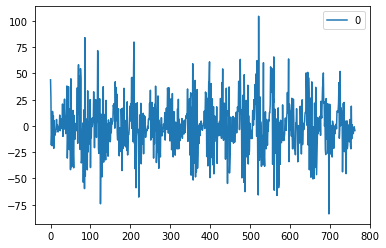

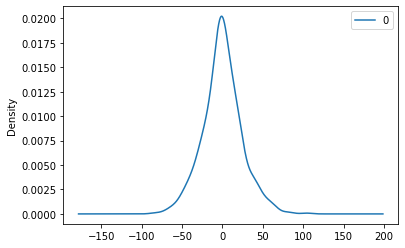

                0
count  763.000000
mean    -0.008501
std     24.287276
min    -83.815767
25%    -13.998875
50%     -0.429449
75%     13.625585
max    104.519168


In [74]:
arima_model_1, train_1, test_1, _, predict_serie = arima_model_sunspot(resample_q, "1999-01-01", "2009-01-01", 2, 1, 1, 70*4)

C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\alice\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


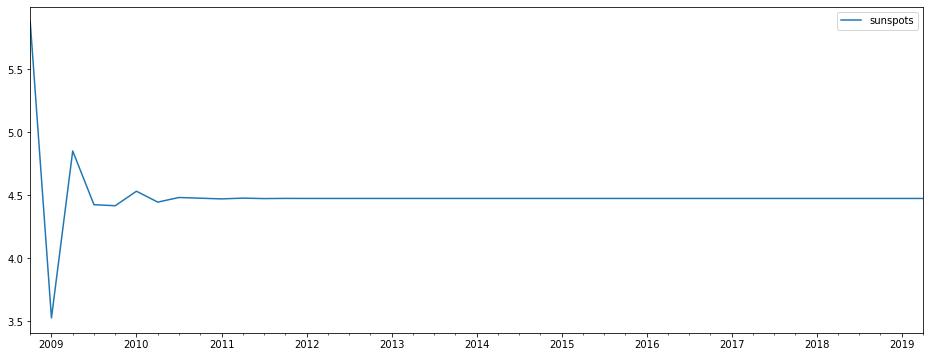

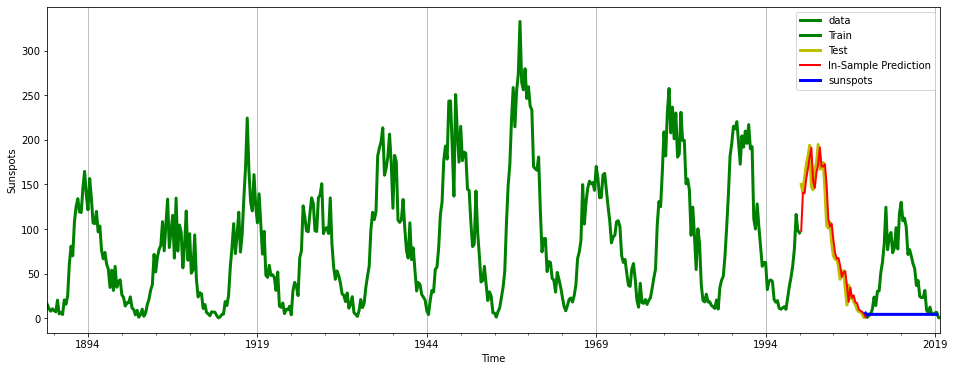

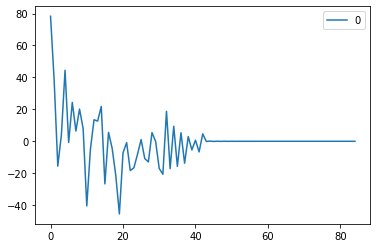

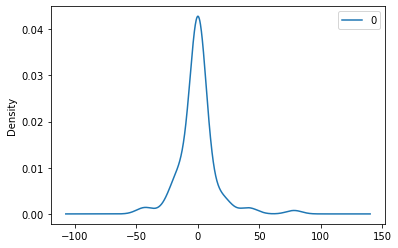

                  0
count  8.500000e+01
mean  -5.746267e-02
std    1.533725e+01
min   -4.548587e+01
25%   -7.384504e-01
50%   -5.017722e-07
75%    6.158964e-02
max    7.831868e+01


In [75]:
_ = predict_future(resample_q, arima_model_1, 43, train_1, test_1, 2, 1, 1, 70*4, predict_serie)

Utilizzando q=1 viene meno la parte corrispondente alla media mobile. L'errore medio è -0.007536, ovvero si ha una sottostima della distribuzione. é minore in modulo rispetto ai casi precedenti, anche se la predizione tende ad appiattirsi prima.
#### p=2 d=1 q=3

(725, 1) (39, 1)


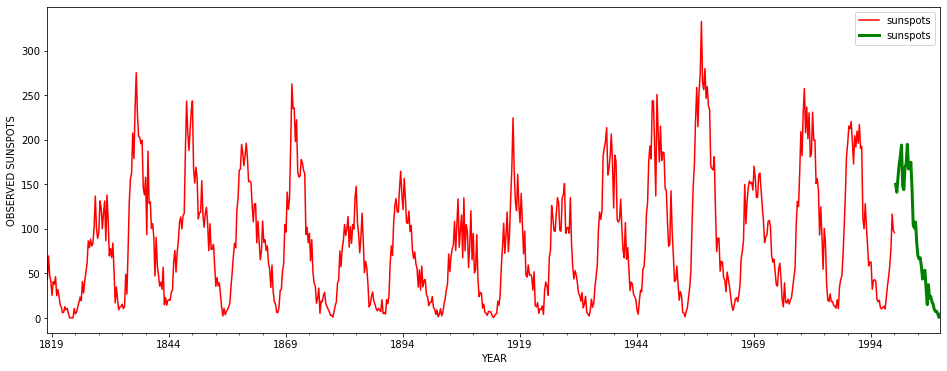

Test RMSE: 17.344


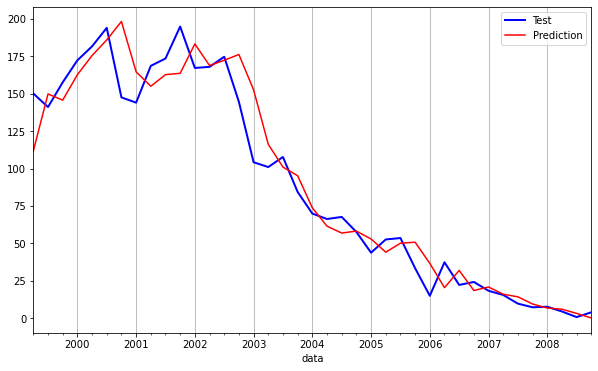

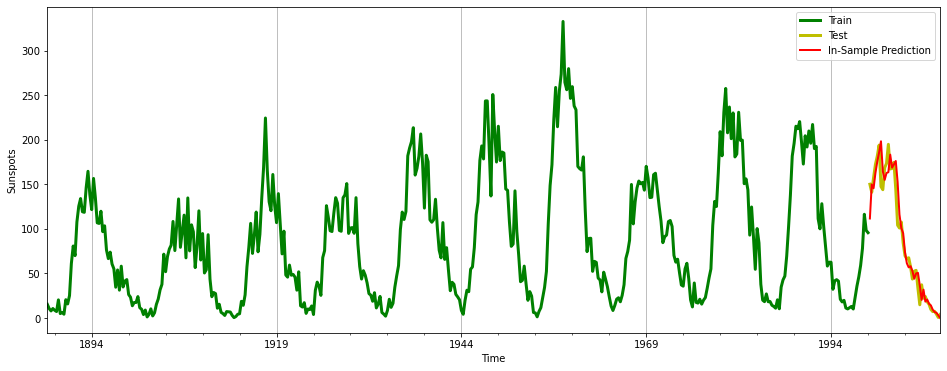

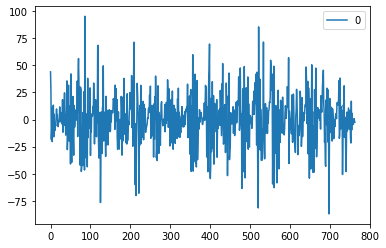

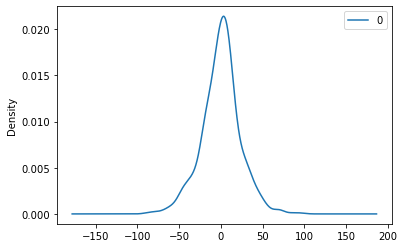

                0
count  763.000000
mean     0.017758
std     23.234511
min    -87.091379
25%    -13.159618
50%      0.998400
75%     11.852809
max     95.281957


In [76]:
arima_model_1, train_1, test_1, _, predict_serie = arima_model_sunspot(resample_q, "1999-01-01", "2009-01-01", 2, 1, 3, 70*4)

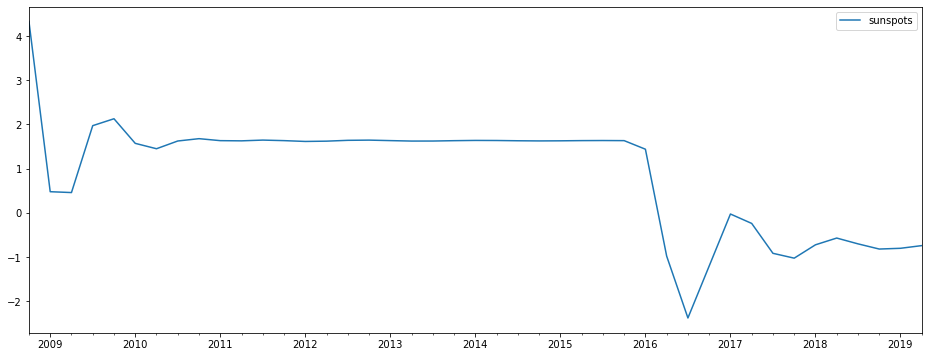

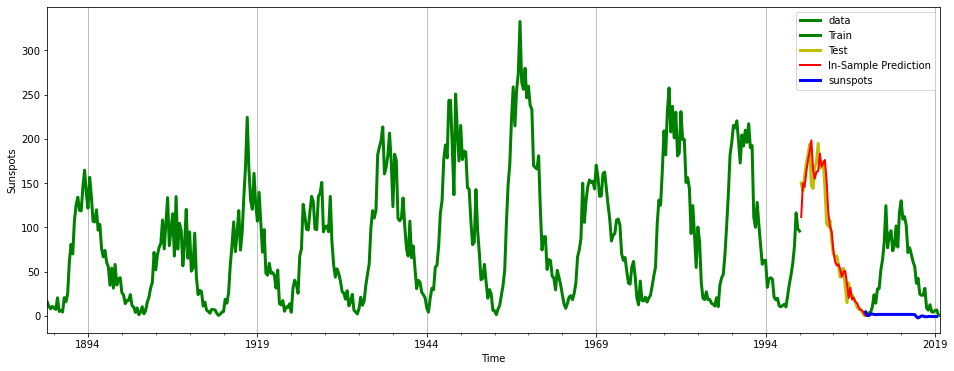

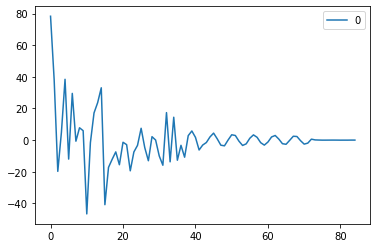

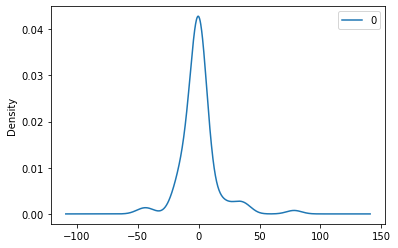

               0
count  85.000000
mean    0.321327
std    15.208617
min   -46.662671
25%    -3.294671
50%    -0.017296
75%     2.283763
max    78.318681


In [77]:
_ = predict_future(resample_q, arima_model_1, 43, train_1, test_1, 2, 1, 3, 70*4, predict_serie)

Errore simile ai casi in cui p=2 d=1 q=2 e p=3 d=1 q=2. \
#### p=3 d=1 q=3

(725, 1) (39, 1)


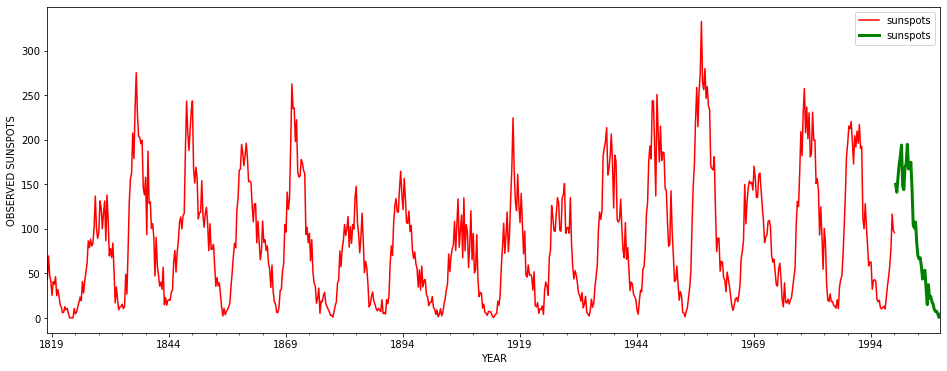

Test RMSE: 17.192


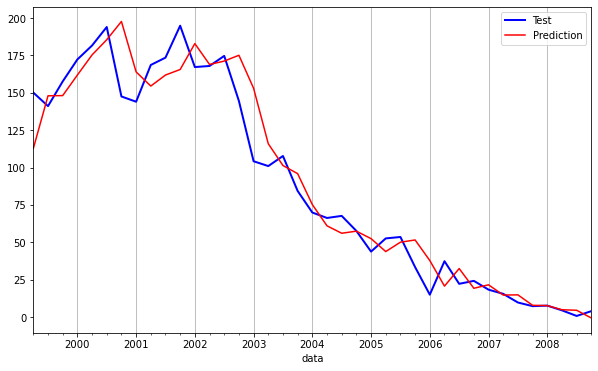

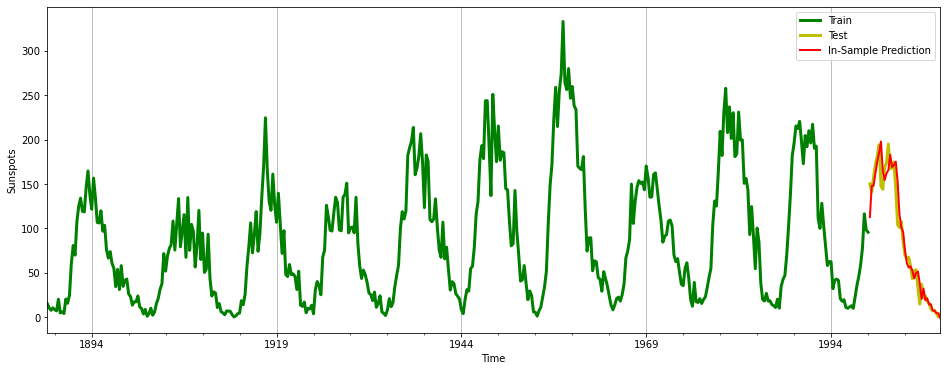

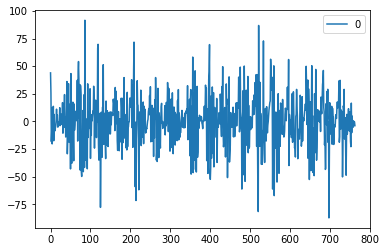

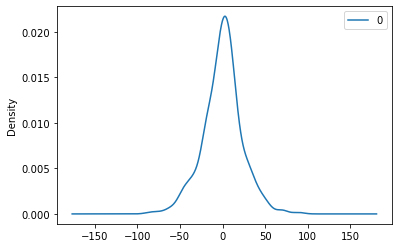

                0
count  763.000000
mean     0.017380
std     23.171643
min    -87.229390
25%    -13.550130
50%      0.667176
75%     12.165529
max     91.549738


In [78]:
arima_model_1, train_1, test_1, _, predict_serie = arima_model_sunspot(resample_q,"1999-01-01", "2009-01-01", 3, 1, 3, 70*4)

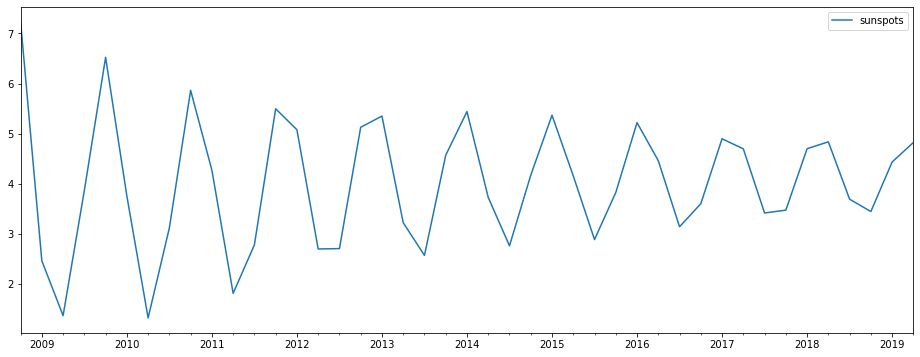

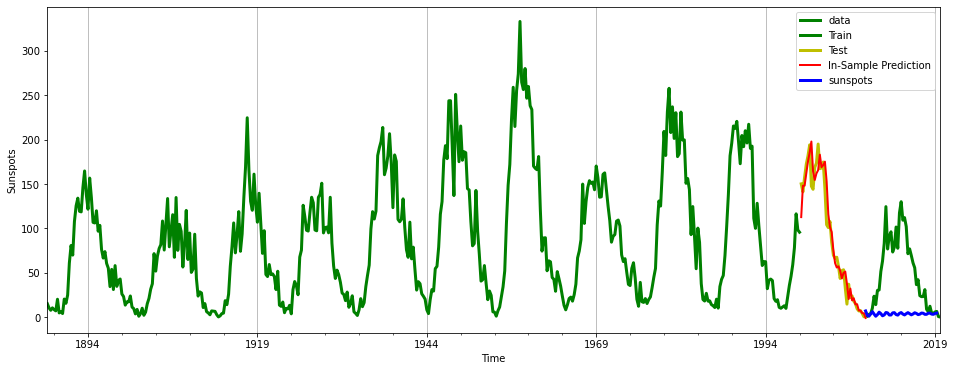

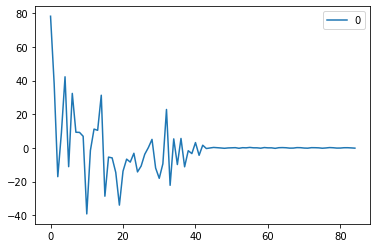

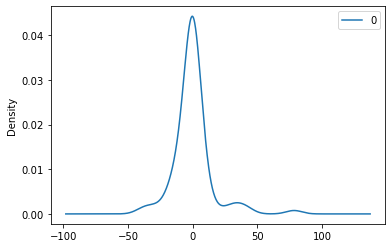

               0
count  85.000000
mean    0.127705
std    14.944649
min   -39.283183
25%    -3.393596
50%    -0.012578
75%     0.182514
max    78.318681


In [79]:
_ = predict_future(resample_q, arima_model_1, 43, train_1, test_1, 3, 1, 3, 70*4, predict_serie)

Errore simile ai casi precedenti. \
L'errore minore sulla predizione del test (fase di allenamento) si ha nel caso in cui p=2 d=1 e q=1 ma anche gli altri casi hanno un errore medio accettabile. In tutti i casi però la predizione non viene fatta correttamente.

Consultati: \
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ (rolling forecast ARIMA model) \
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html

#### Confronto tra gli istogrammi del numero di macchie solari

(array([244., 141., 125., 113.,  72.,  63.,  27.,  19.,   3.,   1.]),
 array([  0.        ,  33.27065217,  66.54130435,  99.81195652,
        133.0826087 , 166.35326087, 199.62391304, 232.89456522,
        266.16521739, 299.43586957, 332.70652174]),
 <BarContainer object of 10 artists>)

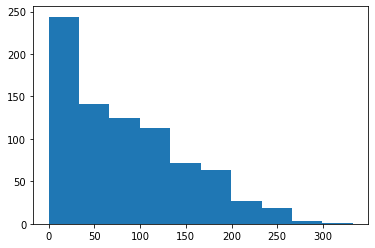

In [80]:
#Campione totale
plt.hist(resample_q.values)

(array([ 5.,  2.,  3., 18., 13.,  0.,  1.,  0.,  0.,  1.]),
 array([-19.75732989, -18.05392211, -16.35051433, -14.64710655,
        -12.94369877, -11.24029099,  -9.53688321,  -7.83347544,
         -6.13006766,  -4.42665988,  -2.7232521 ]),
 <BarContainer object of 10 artists>)

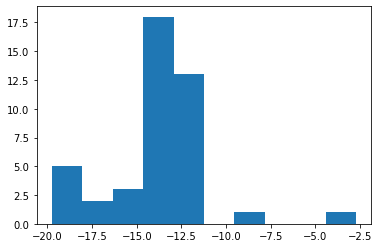

In [81]:
#campione predetto
plt.hist(predict_serie_out_212.values)

(array([9., 4., 4., 3., 1., 3., 0., 5., 7., 3.]),
 array([  0.69565217,  20.11413043,  39.5326087 ,  58.95108696,
         78.36956522,  97.78804348, 117.20652174, 136.625     ,
        156.04347826, 175.46195652, 194.88043478]),
 <BarContainer object of 10 artists>)

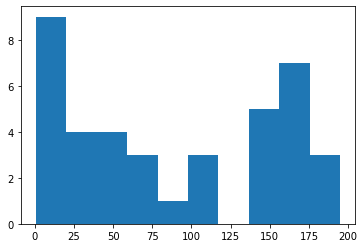

In [82]:
#campione test
plt.hist(test.values)

Si osserva che l'istogramma de valori predetti ha una distribuzione completamente differente rispetto alle distribuzioni dei campioni (totale e test). Quindi il numero di macchie non viene predetto in maniera corretta. 

## Sarima 

Prove per trovare il miglior set di parametri con diversi split tra train e test

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
def sarima_model_sunspot(data, order, s_order, time_split, offset, months_to_predict):
    
    train = data[data.index <= time_split]
    test = data[data.index > time_split] 
    print(train.shape, test.shape)
    
    model_sarima = SARIMAX(train, trend='n', order = order, seasonal_order = s_order, enforce_stationarity = False)
    fitted_model_sarima = model_sarima.fit()
    print(fitted_model_sarima.summary())
    forecast = fitted_model_sarima.predict(start = train.index[-2], end= train.index[-2] + pd.DateOffset(months=months_to_predict)) 
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
    train[offset:].plot(ax = ax1, color = "y", lw = 2, label = "train")
    test.plot(ax = ax1, color = "g", lw = 2, label = "test")
    forecast.plot(ax = ax1, color = "r", lw = 2, label = "prediction")
    ax1.set_xlabel("Time"); ax1.set_ylabel("Sunspots"); plt.legend()
    ax1.xaxis.grid()
    
    #line plot of residuals
    residuals = pd.DataFrame(fitted_model_sarima.resid)
    plt.figure(figsize=(16,3))
    plt.plot(residuals, color = "#FF7080")
    plt.xlabel("Time"); plt.ylabel("Residual")
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())
    
    return fitted_model_sarima, train, test


(765, 1) (43, 1)
                                        SARIMAX Results                                        
Dep. Variable:                                sunspots   No. Observations:                  765
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 43)   Log Likelihood               -2923.842
Date:                                 Mon, 22 Feb 2021   AIC                           5859.684
Time:                                         13:25:56   BIC                           5886.396
Sample:                                     01-01-1818   HQIC                          5870.057
                                          - 01-01-2009                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9281      0.015     63.792      0.000   

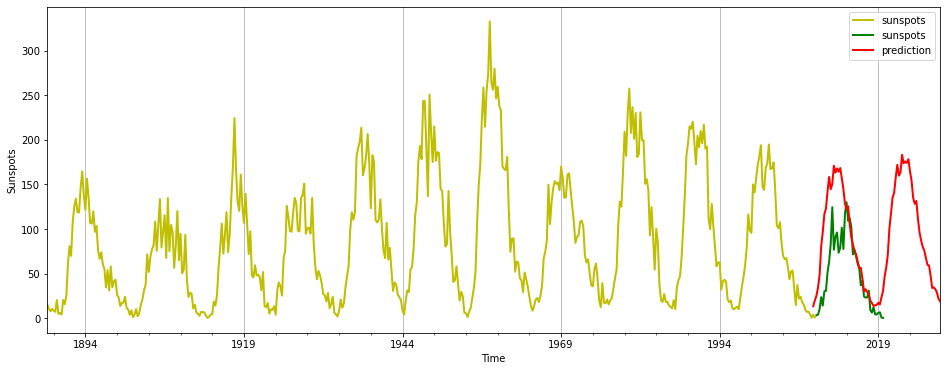

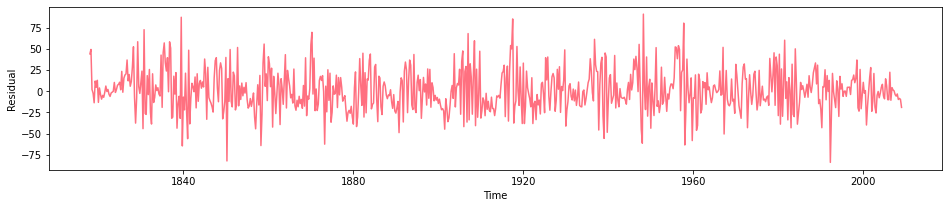

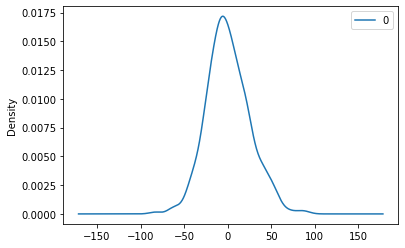

                0
count  765.000000
mean     0.633751
std     24.867063
min    -83.944586
25%    -16.184980
50%     -1.213105
75%     15.828217
max     90.784330


In [84]:
order = (1,0,1)
s_order = (1,1,2,43)
_, _, _ = sarima_model_sunspot(resample_q, order, s_order,  '2009-01-01', 70*4, 12*20) 

(765, 1) (43, 1)
                                     SARIMAX Results                                      
Dep. Variable:                           sunspots   No. Observations:                  765
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 43)   Log Likelihood               -2912.090
Date:                            Mon, 22 Feb 2021   AIC                           5840.180
Time:                                    13:30:28   BIC                           5875.771
Sample:                                01-01-1818   HQIC                          5854.003
                                     - 01-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1434      0.076     15.009      0.000       0.994       1.293
ar.L2         -0.3

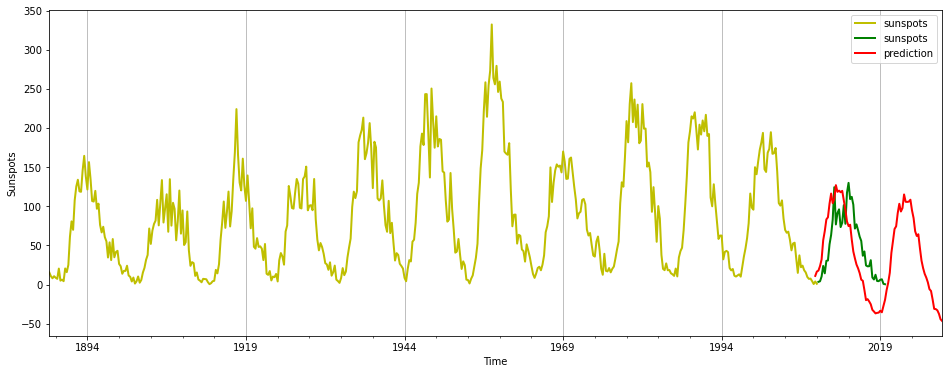

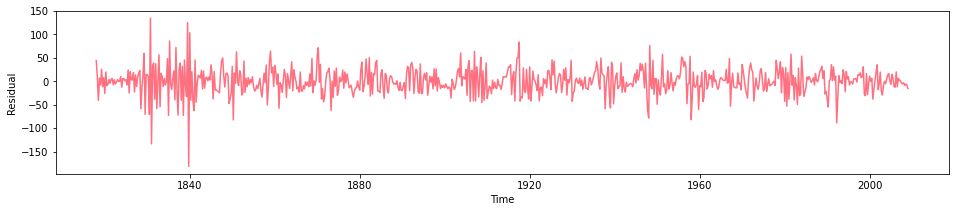

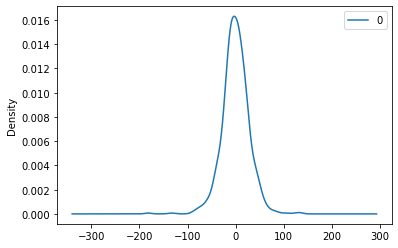

                0
count  765.000000
mean    -0.193415
std     27.868310
min   -181.704998
25%    -15.248162
50%     -0.265858
75%     16.252886
max    134.503368


In [85]:
order = (2,1,2)
s_order = (1,1,2,43)
_, _, _  = sarima_model_sunspot(resample_q, order, s_order,  '2009-01-01', 70*4, 12*20)   

(765, 1) (43, 1)
                                     SARIMAX Results                                      
Dep. Variable:                           sunspots   No. Observations:                  765
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 44)   Log Likelihood               -2887.988
Date:                            Mon, 22 Feb 2021   AIC                           5793.976
Time:                                    13:35:44   BIC                           5833.973
Sample:                                01-01-1818   HQIC                          5809.513
                                     - 01-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1666      0.072     16.127      0.000       1.025       1.308
ar.L2         -0.4

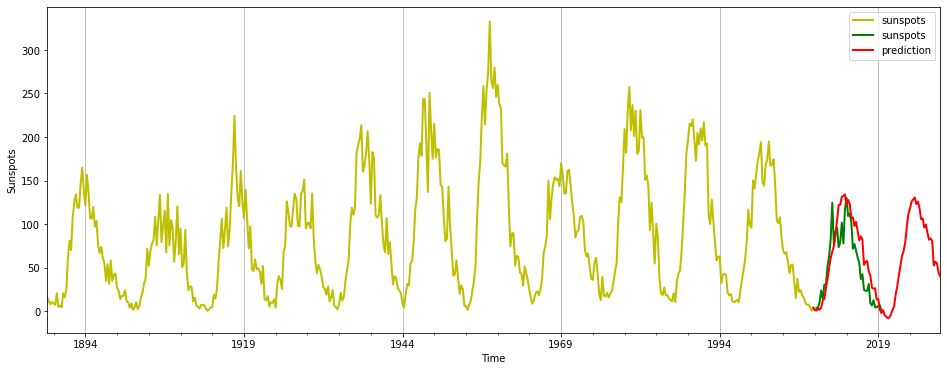

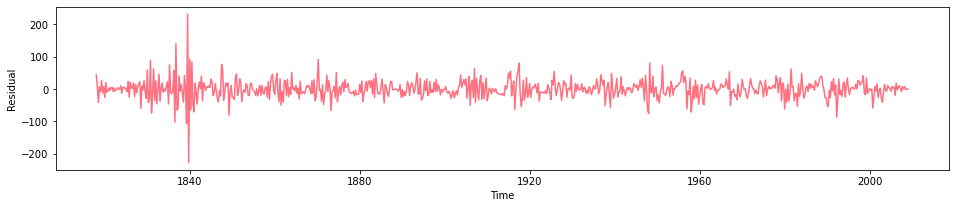

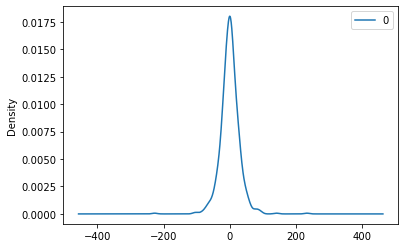

                0
count  765.000000
mean    -0.102788
std     28.958566
min   -227.166474
25%    -14.601482
50%     -0.146196
75%     14.218771
max    232.006915


In [86]:
order = (2,1,2)
s_order = (2,1,2,44)
_, _, _ = sarima_model_sunspot(resample_q, order, s_order,  '2009-01-01', 70*4, 12*20)    

(805, 1) (3, 1)
                                     SARIMAX Results                                      
Dep. Variable:                           sunspots   No. Observations:                  805
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 44)   Log Likelihood               -3063.327
Date:                            Mon, 22 Feb 2021   AIC                           6144.654
Time:                                    13:40:55   BIC                           6185.207
Sample:                                01-01-1818   HQIC                          6160.363
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1299      0.078     14.559      0.000       0.978       1.282
ar.L2         -0.36

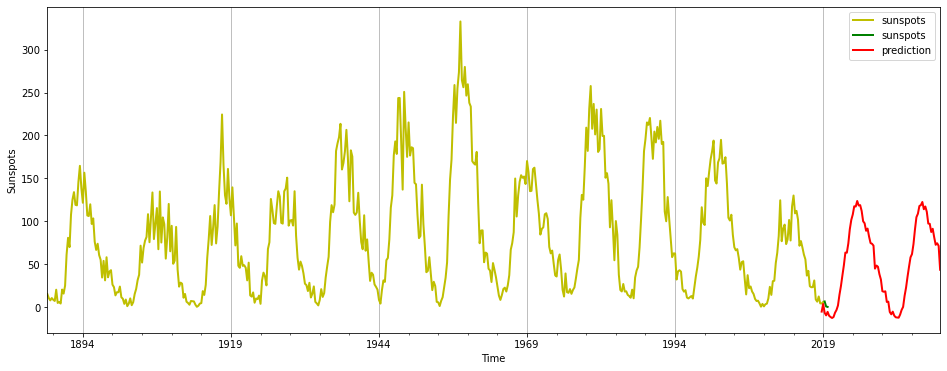

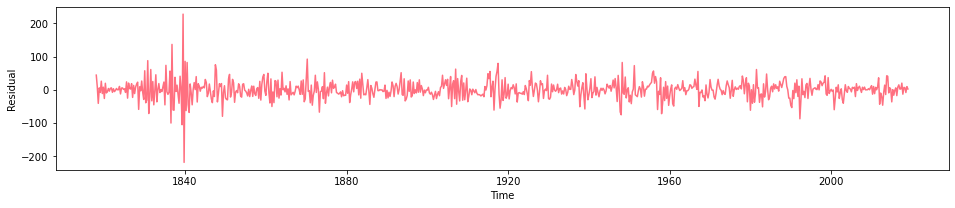

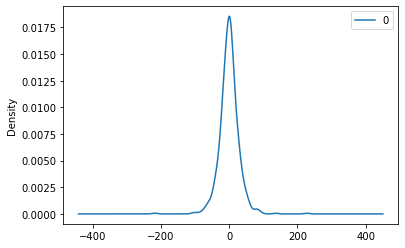

                0
count  805.000000
mean    -0.103656
std     28.238941
min   -218.536240
25%    -14.407894
50%      0.016236
75%     13.823688
max    227.460516


In [87]:
#train = resample 
order = (2,1,2)
s_order = (2,1,2,44)
fitted_model_sarima, train_sarima, test_sarima = sarima_model_sunspot(resample_q, order, s_order,'2019-01-01', 70*4, 12*20)  

Provo utilizzando get_prediction al posto di predict per vedere se ci sono differenze in questa ultima previsione

In [91]:
prediction_sarima = fitted_model_sarima.get_prediction(end= resample_q.index[-44] + pd.DateOffset(months=20*12)).summary_frame()

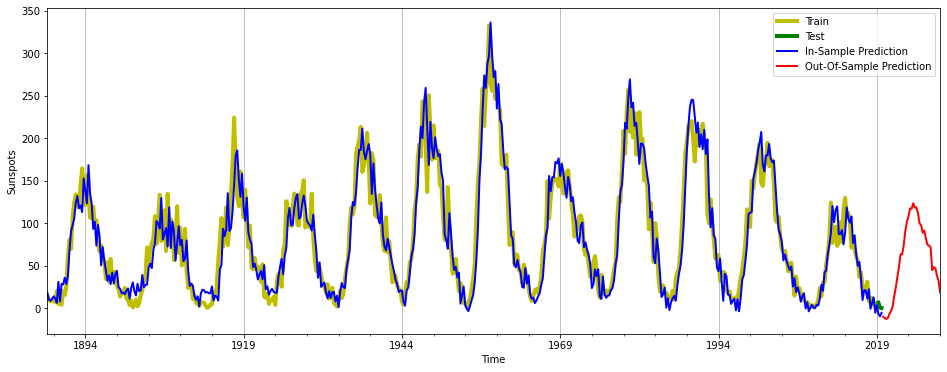

In [95]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

train_sarima.sunspots[70*4:].plot(ax = ax1, color = "y", lw = 4, label = "Train") #[150*4:]
test_sarima.sunspots.plot(ax = ax1, color = "g", lw = 4, label = "Test")
prediction_sarima["mean"][70*4:808].plot(ax = ax1, color = "b", lw = 2, label = "In-Sample Prediction") 
prediction_sarima["mean"][808:].plot(ax = ax1, color = "r", lw = 2, label = "Out-Of-Sample Prediction")

ax1.set_xlabel("Time"); ax1.set_ylabel("Sunspots"); plt.legend()
ax1.xaxis.grid()

                0
count  805.000000
mean    -0.103656
std     28.238941
min   -218.536240
25%    -14.407894
50%      0.016236
75%     13.823688
max    227.460516


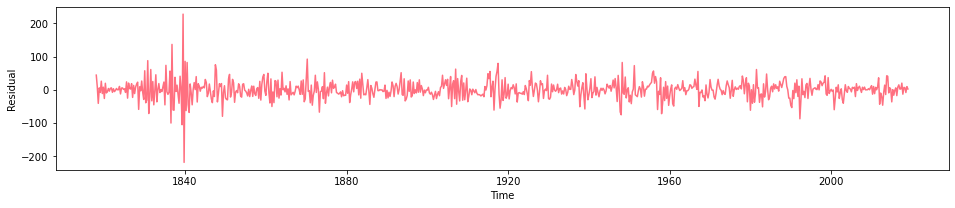

In [96]:
residuals = pd.DataFrame(fitted_model_sarima.resid)
plt.figure(figsize=(16,3))
plt.plot(residuals, color = "#FF7080")
plt.xlabel("Time"); plt.ylabel("Residual")
print(residuals.describe())
    

get_predict predice come predict, anche la distribuzione dei residui è la stessa. \
In generale con SARIMA si riesce a predirre bene un ciclo solare (10 anni), il secondo ciclo predetto in alcuni casi sembra una ripetizione del primo. L'errore medio è basso e anche la disribuzione è buona, fanno eccezione l'anno 1840 e qualche picco più pronunciato. Il modello non riesce a predirre bene l'andamento frastagliato che comunque ricostruisce nella fase di allenamento. é possibile che una ottimizzazione dei parametri migliori la predizione. 